In [2]:
import sys
from pathlib import Path

# Add the notebooks directory to the path
sys.path.append(str(Path.cwd().parent))

import pandas as pd
from charts import (
    cpu_chart,
    cpu_chart_nodes,
    cpu_chart_stacked,
    gantt_chart,
    kafka_charts,
    memory_chart,
    memory_chart_nodes,
    memory_chart_stacked,
    minio_charts,
)
from utils import get_selected_pods, time_filter

experiment_name = "final-01"

start_time = pd.Timestamp("2026-01-05 15:30:00").tz_localize("America/Sao_Paulo")
end_time = pd.Timestamp("2026-01-05 17:30:00").tz_localize("America/Sao_Paulo")

---

# Edge Data

In [3]:
base_path = f"../../data/raw/{experiment_name}/{experiment_name}_edge"
df_container_cpu_usage_seconds_total = pd.read_parquet(base_path + "/container_cpu_usage_seconds_total.parquet")
df_container_memory_usage_bytes = pd.read_parquet(base_path + "/container_memory_usage_bytes.parquet")
df_kube_pod_status_phase = pd.read_parquet(base_path + "/kube_pod_status_phase.parquet")

kafka_bytes_in = pd.read_parquet(base_path + "/kafka_server_brokertopicmetrics_bytesin_total.parquet")
kafka_bytes_out = pd.read_parquet(base_path + "/kafka_server_brokertopicmetrics_bytesout_total.parquet")
kafka_messages_in = pd.read_parquet(base_path + "/kafka_server_brokertopicmetrics_messagesin_total.parquet")
kafka_requests = pd.read_parquet(base_path + "/kafka_network_requestmetrics_requests_total.parquet")
kafka_requests_errors = pd.read_parquet(base_path + "/kafka_network_requestmetrics_errors_total.parquet")

# === Load all MinIO metric CSVs ===
df_minio_incoming = time_filter(pd.read_parquet(base_path + '/minio_s3_requests_incoming_total.parquet').reset_index(), start_time, end_time)
df_minio_total = time_filter(pd.read_parquet(base_path + '/minio_s3_requests_total.parquet').reset_index(), start_time, end_time)
df_minio_waiting = time_filter(pd.read_parquet(base_path + '/minio_s3_requests_waiting_total.parquet').reset_index(), start_time, end_time)
df_minio_errors = time_filter(pd.read_parquet(base_path + '/minio_s3_requests_errors_total.parquet').reset_index(), start_time, end_time)
df_minio_sent_bytes = time_filter(pd.read_parquet(base_path + '/minio_s3_traffic_sent_bytes.parquet').reset_index(), start_time, end_time)
df_minio_received_bytes = time_filter(pd.read_parquet(base_path + '/minio_s3_traffic_received_bytes.parquet').reset_index(), start_time, end_time)

df_container_cpu_usage_seconds_total = df_container_cpu_usage_seconds_total.reset_index()
df_container_memory_usage_bytes = df_container_memory_usage_bytes.reset_index()
df_kube_pod_status_phase = df_kube_pod_status_phase.reset_index()

kafka_bytes_in = kafka_bytes_in.reset_index()
kafka_bytes_out = kafka_bytes_out.reset_index()
kafka_messages_in = kafka_messages_in.reset_index()
kafka_requests = kafka_requests.reset_index()
kafka_requests_errors = kafka_requests_errors.reset_index()

df_container_cpu_usage_seconds_total = time_filter(df_container_cpu_usage_seconds_total, start_time, end_time)
df_container_memory_usage_bytes = time_filter(df_container_memory_usage_bytes, start_time, end_time)
df_kube_pod_status_phase = time_filter(df_kube_pod_status_phase, start_time, end_time)

kafka_bytes_in = time_filter(kafka_bytes_in, start_time, end_time)
kafka_bytes_out = time_filter(kafka_bytes_out, start_time, end_time)
kafka_messages_in = time_filter(kafka_messages_in, start_time, end_time)
kafka_requests = time_filter(kafka_requests, start_time, end_time)
kafka_requests_errors = time_filter(kafka_requests_errors, start_time, end_time)

selected_pods = get_selected_pods(df_kube_pod_status_phase)

# Filter distributed Minio
selected_pods = [
    pod for pod in selected_pods if not pod.startswith("minio-community")
]

NODE_CPU_LIMITS = {
    "server-k8s-w01": 400,
    "server-k8s-w02": 400,
    "server-k8s-w03": 400,
    "server-k8s-w04": 400,
}

memory = 8.192 * 1 # 8 GB

NODE_MEMORY_LIMITS = {
    "server-k8s-w01": memory,
    "server-k8s-w02": memory,
    "server-k8s-w03": memory,
    "server-k8s-w04": memory,
}

df_kube_pod_status_phase = df_kube_pod_status_phase[df_kube_pod_status_phase["pod"].isin(selected_pods)]
df_container_cpu_usage_seconds_total_filtered = df_container_cpu_usage_seconds_total[df_container_cpu_usage_seconds_total["pod"].isin(selected_pods)]
df_container_memory_usage_bytes_filtered = df_container_memory_usage_bytes[df_container_memory_usage_bytes["pod"].isin(selected_pods)]
df_minio_incoming = df_minio_incoming[df_minio_incoming["pod"].isin(selected_pods)]
df_minio_total = df_minio_total[df_minio_total["pod"].isin(selected_pods)]
df_minio_waiting = df_minio_waiting[df_minio_waiting["pod"].isin(selected_pods)]
df_minio_errors = df_minio_errors[df_minio_errors["pod"].isin(selected_pods)]
df_minio_sent_bytes = df_minio_sent_bytes[df_minio_sent_bytes["pod"].isin(selected_pods)]
df_minio_received_bytes = df_minio_received_bytes[df_minio_received_bytes["pod"].isin(selected_pods)]

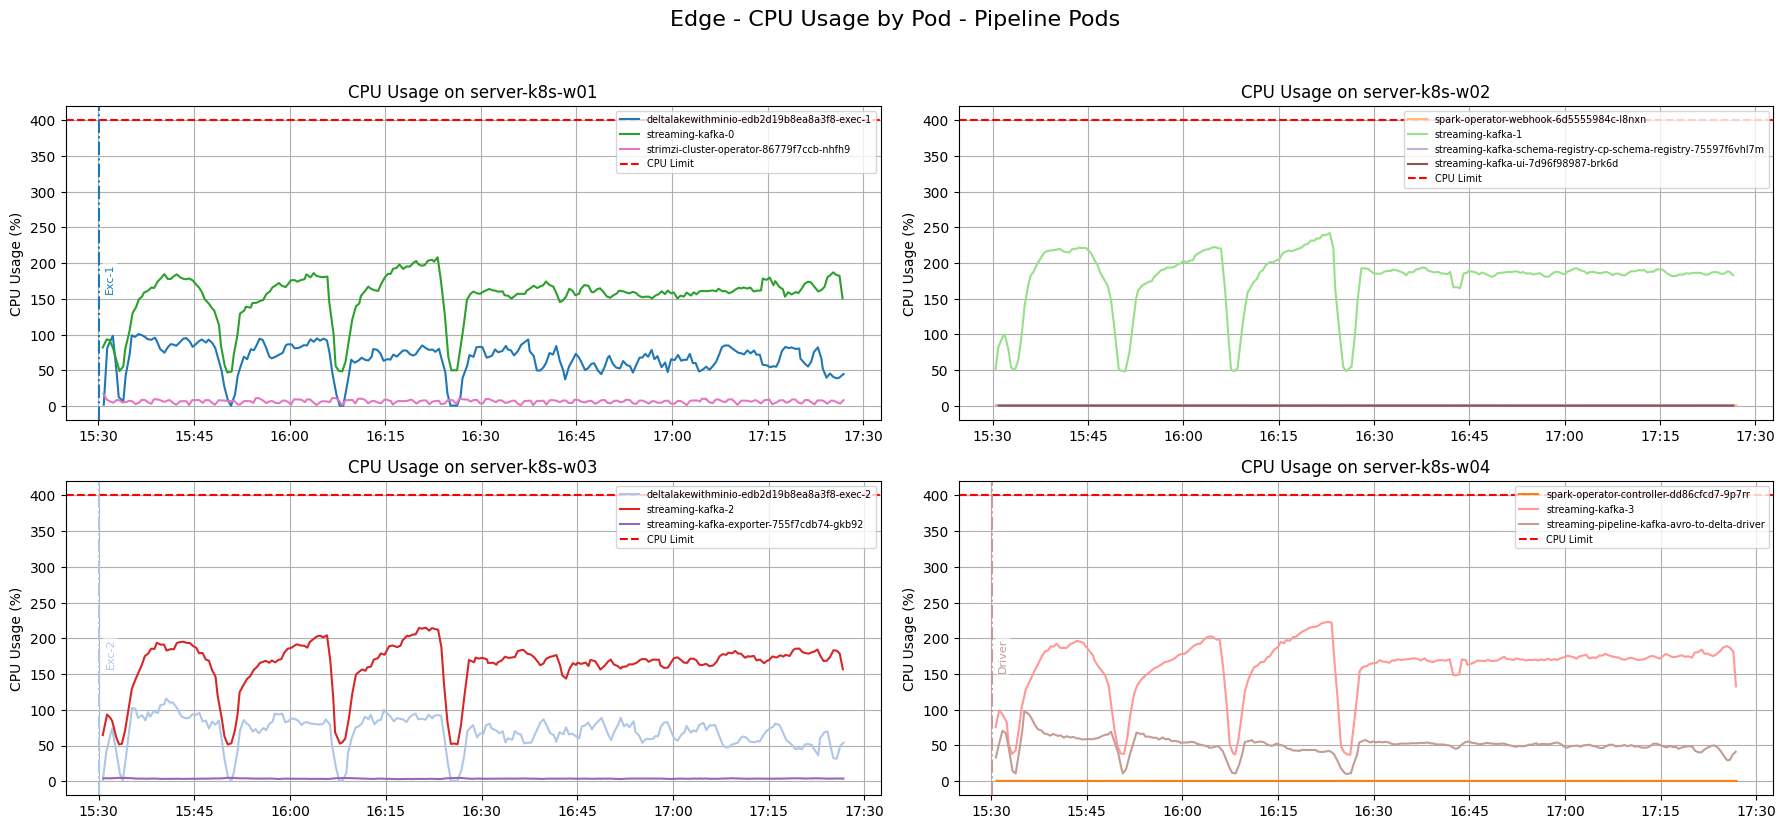

In [4]:
cpu_chart(df_container_cpu_usage_seconds_total_filtered, df_kube_pod_status_phase, title="Edge - CPU Usage by Pod - Pipeline Pods", node_cpu_limits=NODE_CPU_LIMITS)

/home/ark/streaming-pipeline/notebooks/charts.py:214: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .mean(numeric_only=True)  # Ensures only numeric values are averaged


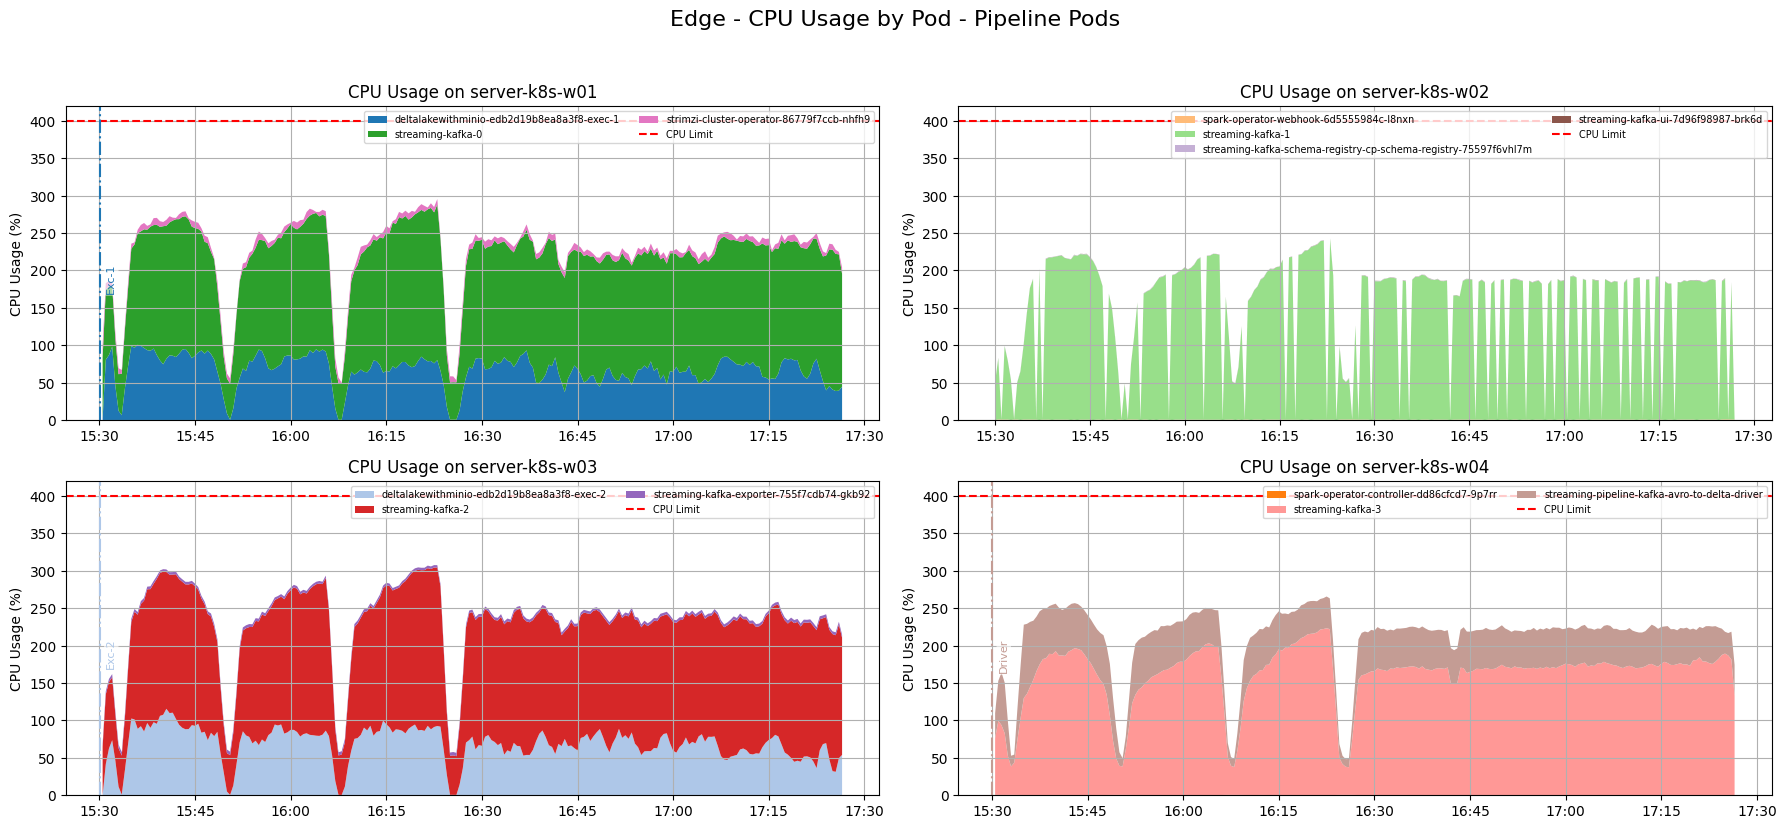

In [5]:
cpu_chart_stacked(df_container_cpu_usage_seconds_total_filtered, df_kube_pod_status_phase, title="Edge - CPU Usage by Pod - Pipeline Pods", node_cpu_limits=NODE_CPU_LIMITS)

/home/ark/streaming-pipeline/notebooks/charts.py:214: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .mean(numeric_only=True)  # Ensures only numeric values are averaged


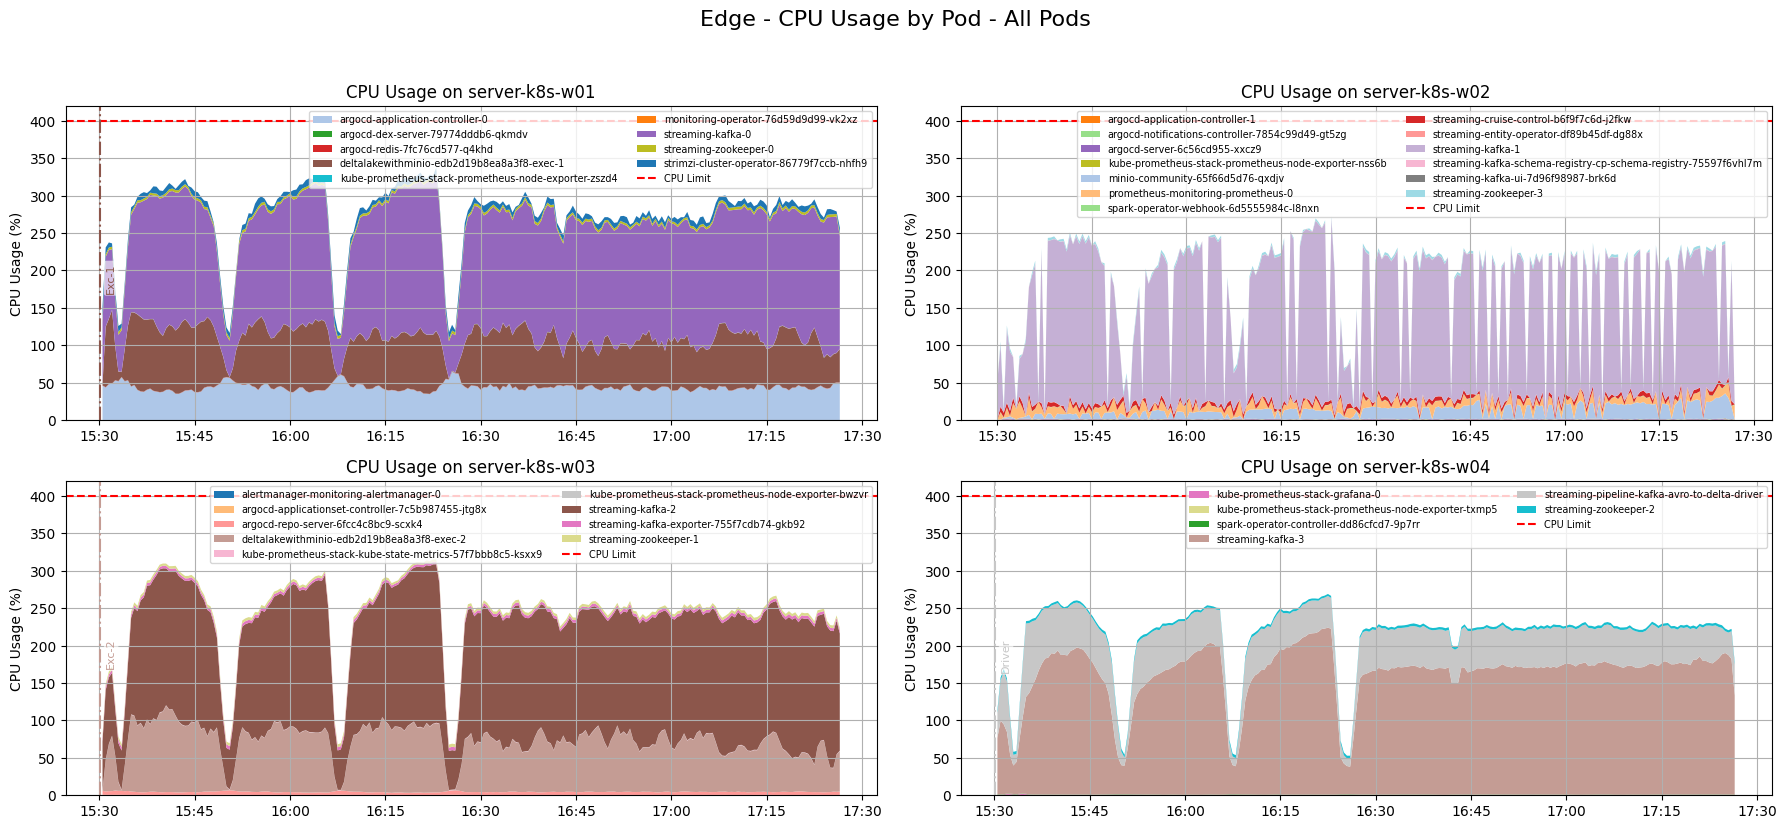

In [7]:
cpu_chart_stacked(df_container_cpu_usage_seconds_total, df_kube_pod_status_phase, title="Edge - CPU Usage by Pod - All Pods", node_cpu_limits=NODE_CPU_LIMITS)

/home/ark/streaming-pipeline/notebooks/charts.py:307: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .mean(numeric_only=True)


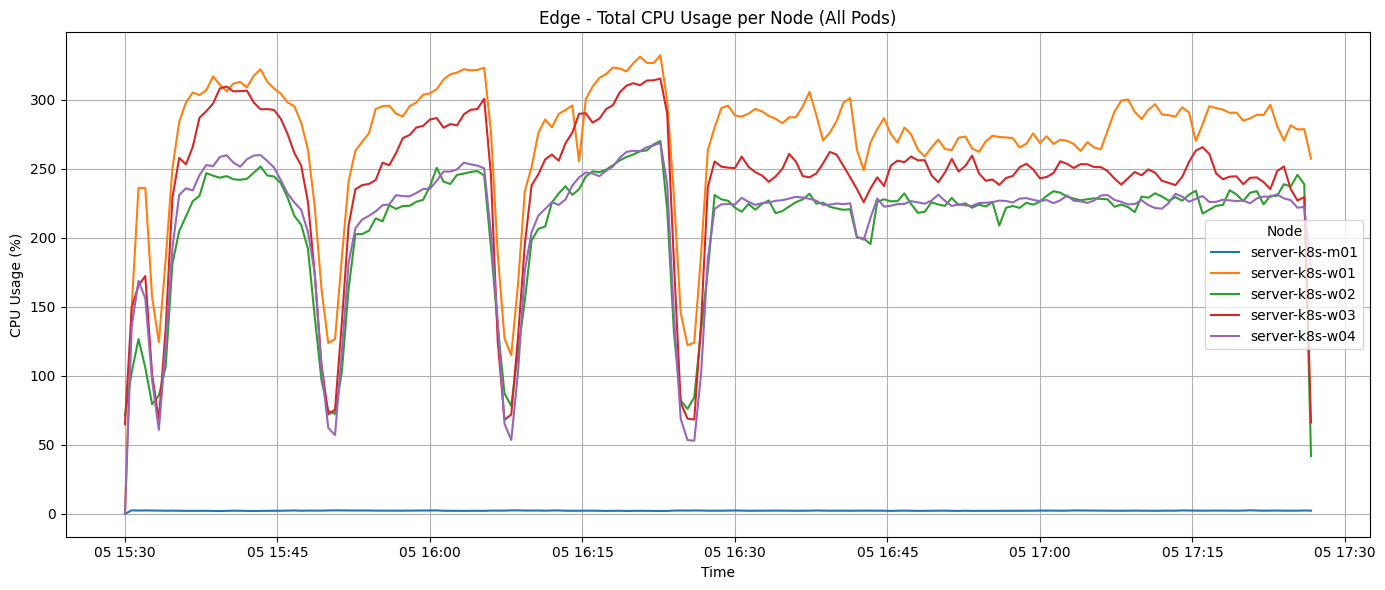

In [8]:
cpu_chart_nodes(df_container_cpu_usage_seconds_total, "Edge - Total CPU Usage per Node (All Pods)")

/home/ark/streaming-pipeline/notebooks/charts.py:307: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .mean(numeric_only=True)


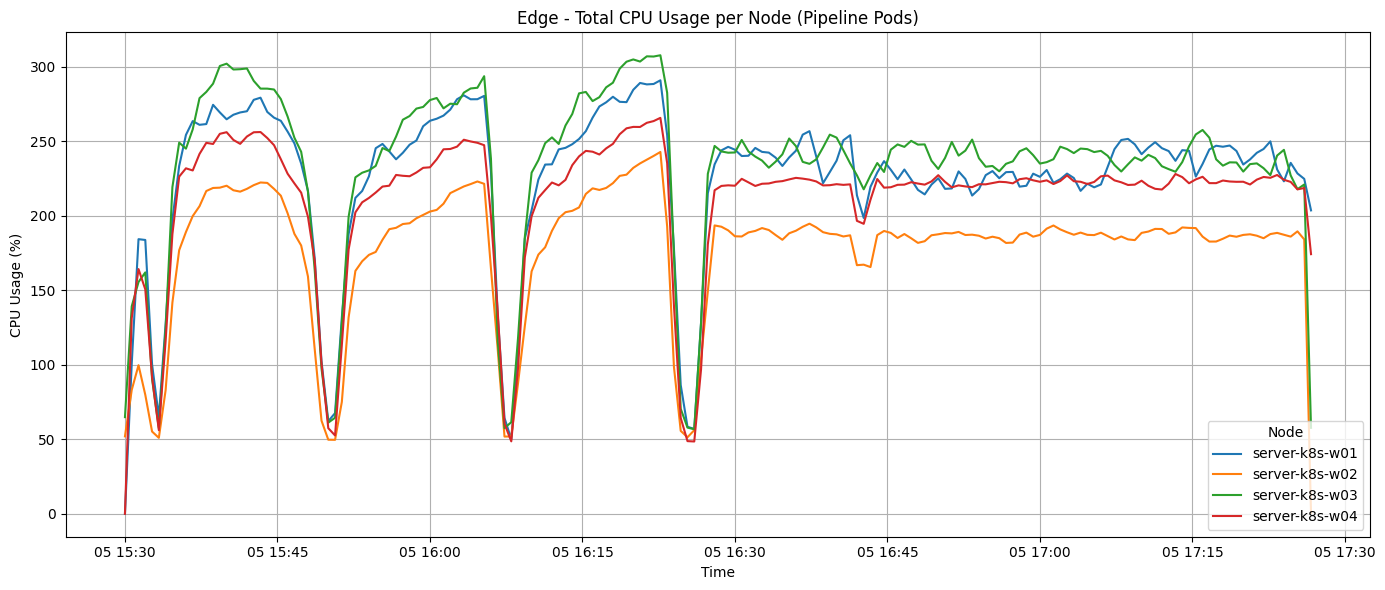

In [9]:
cpu_chart_nodes(df_container_cpu_usage_seconds_total_filtered, "Edge - Total CPU Usage per Node (Pipeline Pods)")

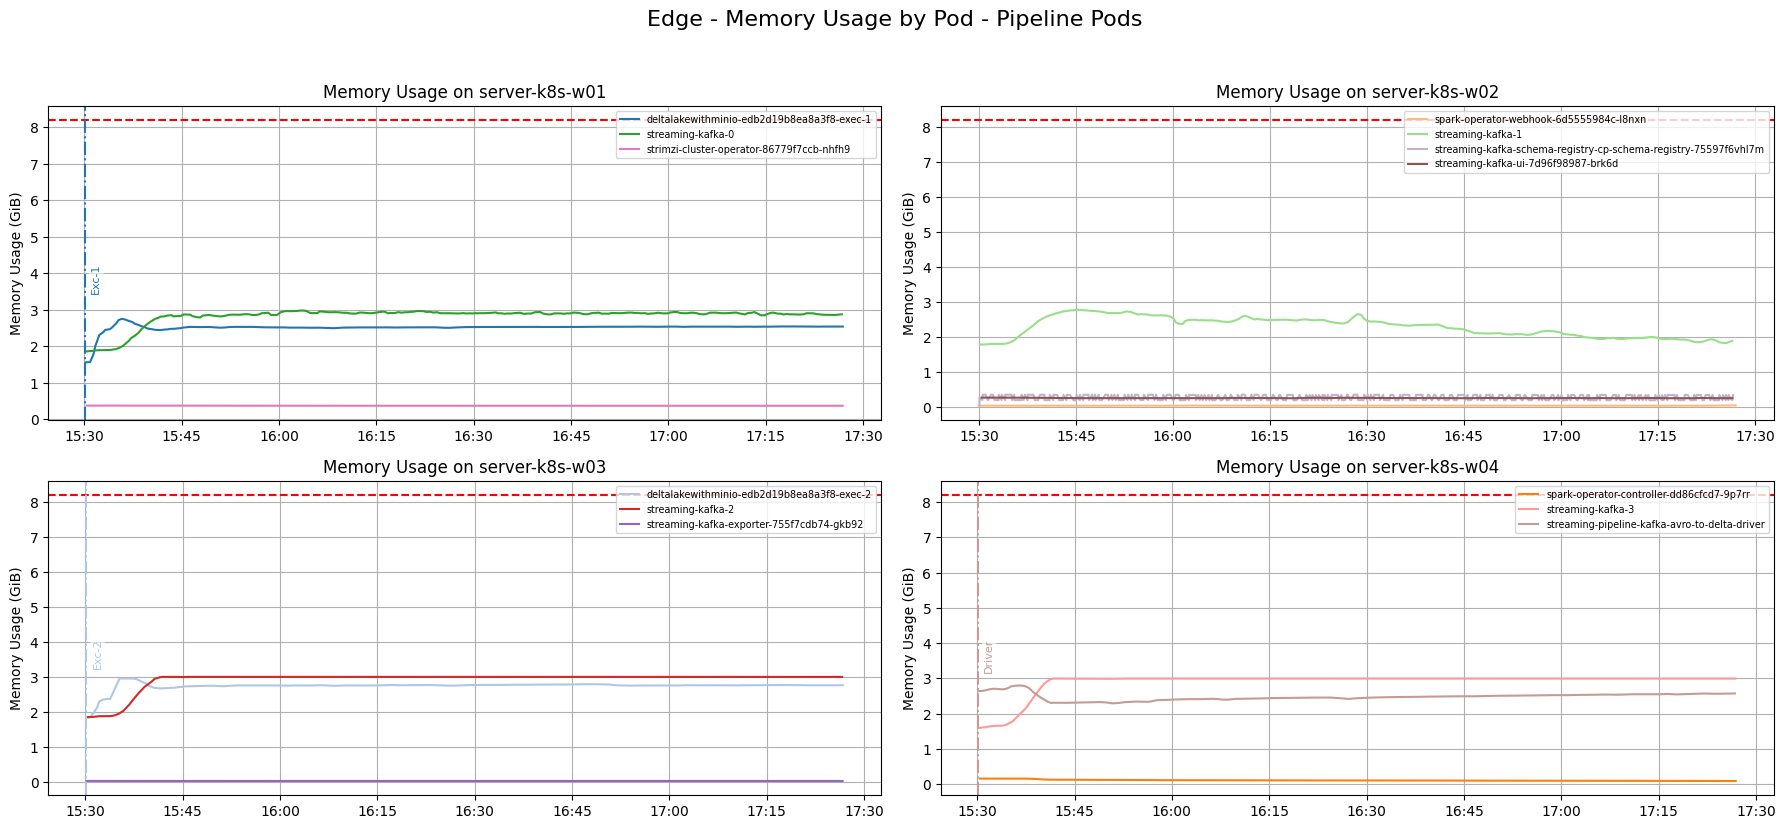

In [10]:
memory_chart(df_container_memory_usage_bytes_filtered, df_kube_pod_status_phase, title="Edge - Memory Usage by Pod - Pipeline Pods", node_memory_limits=NODE_MEMORY_LIMITS)

/home/ark/streaming-pipeline/notebooks/charts.py:442: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .mean(numeric_only=True)


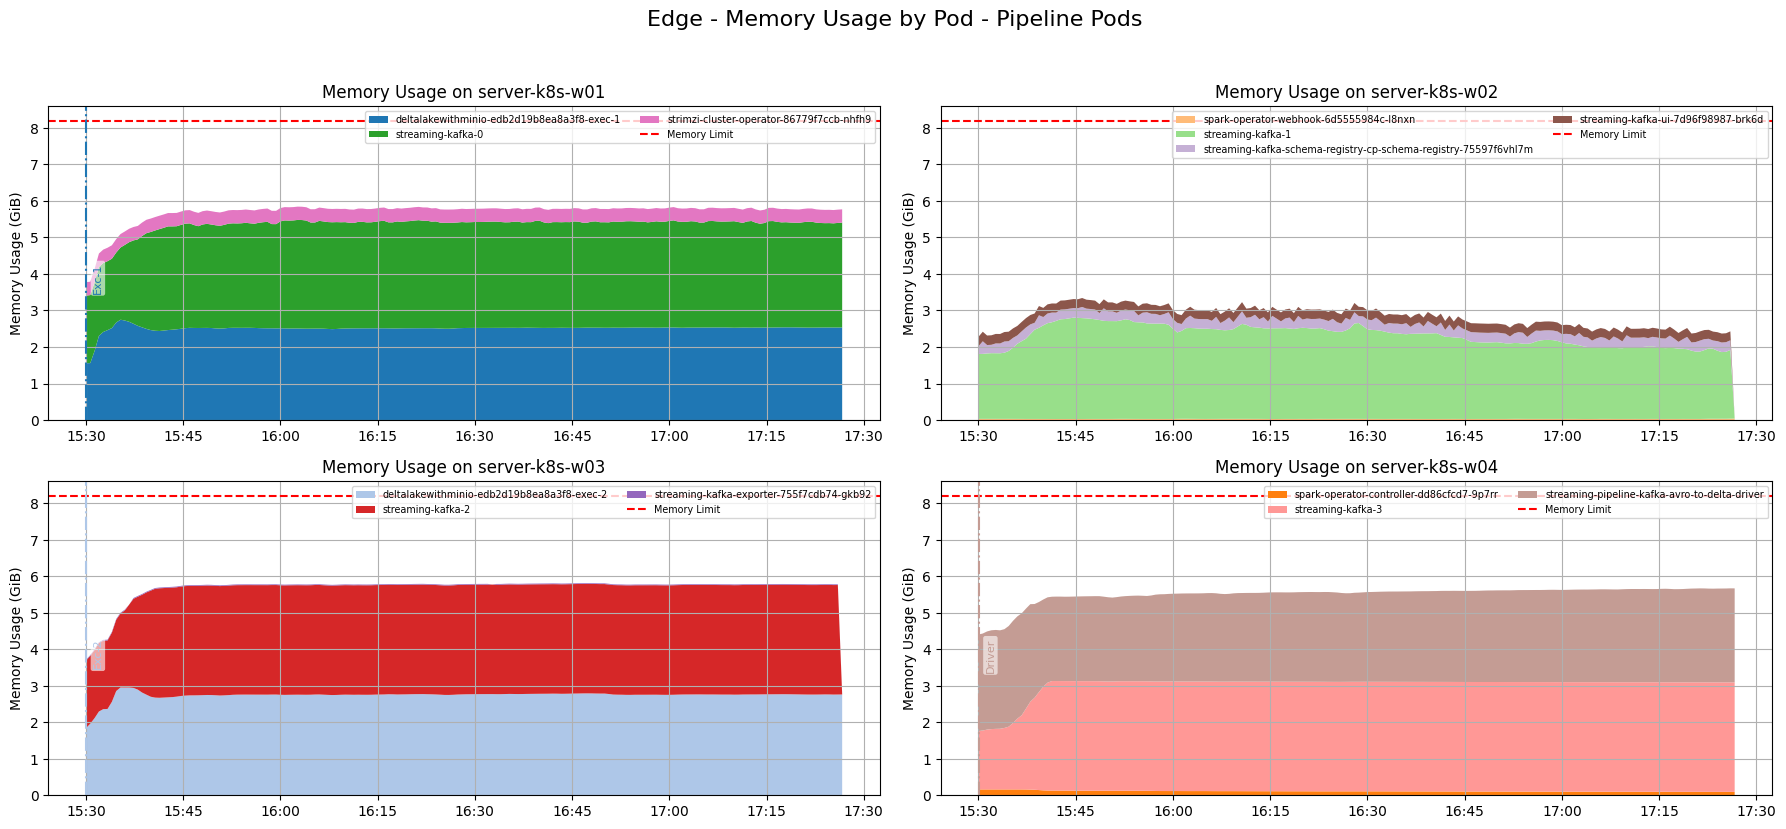

In [11]:
memory_chart_stacked(df_container_memory_usage_bytes_filtered, df_kube_pod_status_phase, title="Edge - Memory Usage by Pod - Pipeline Pods", node_memory_limits=NODE_MEMORY_LIMITS)

/home/ark/streaming-pipeline/notebooks/charts.py:442: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .mean(numeric_only=True)


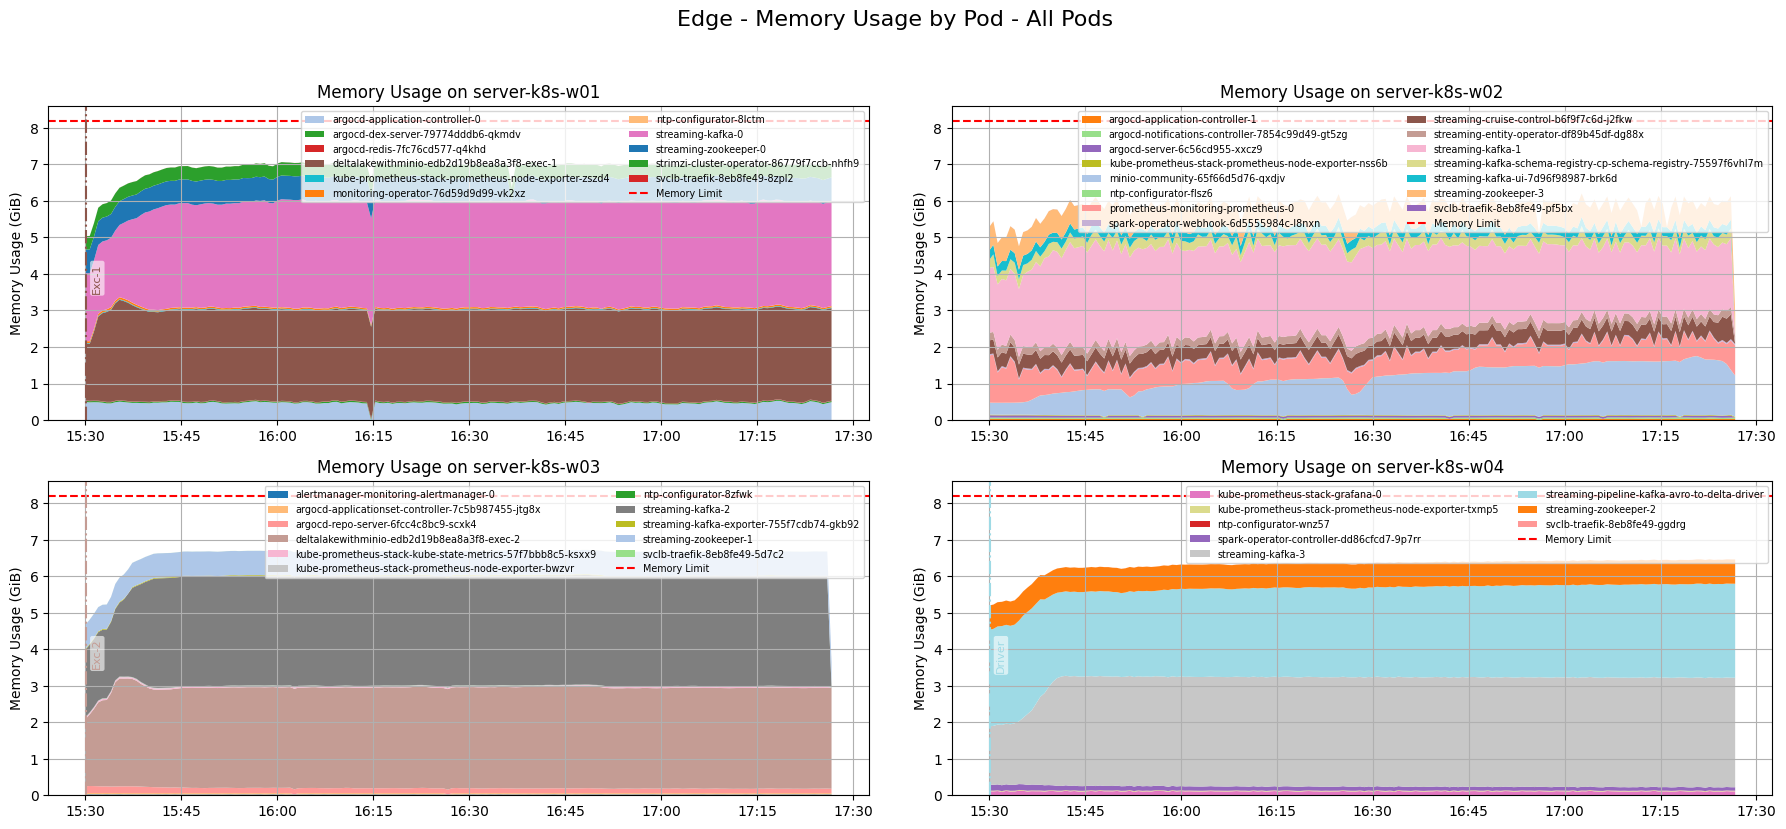

In [12]:
memory_chart_stacked(df_container_memory_usage_bytes, df_kube_pod_status_phase, title="Edge - Memory Usage by Pod - All Pods", node_memory_limits=NODE_MEMORY_LIMITS)

/home/ark/streaming-pipeline/notebooks/charts.py:536: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .mean(numeric_only=True)


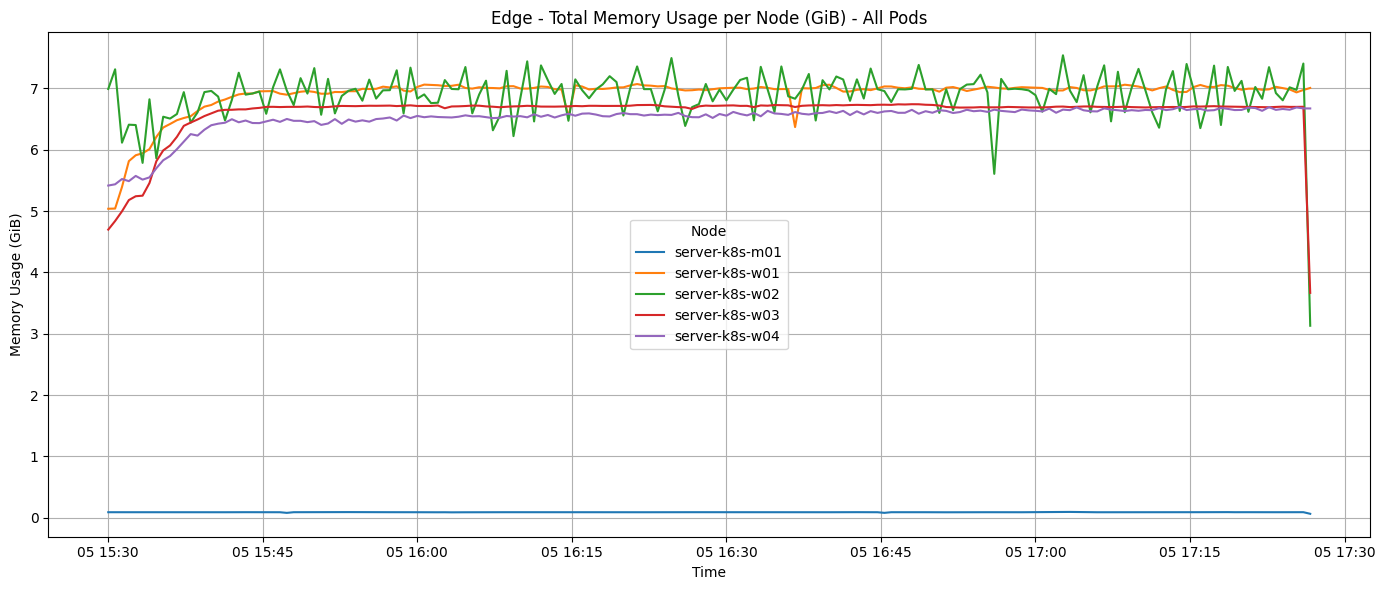

In [13]:
memory_chart_nodes(df_container_memory_usage_bytes, "Edge - Total Memory Usage per Node (GiB) - All Pods")

/home/ark/streaming-pipeline/notebooks/charts.py:536: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .mean(numeric_only=True)


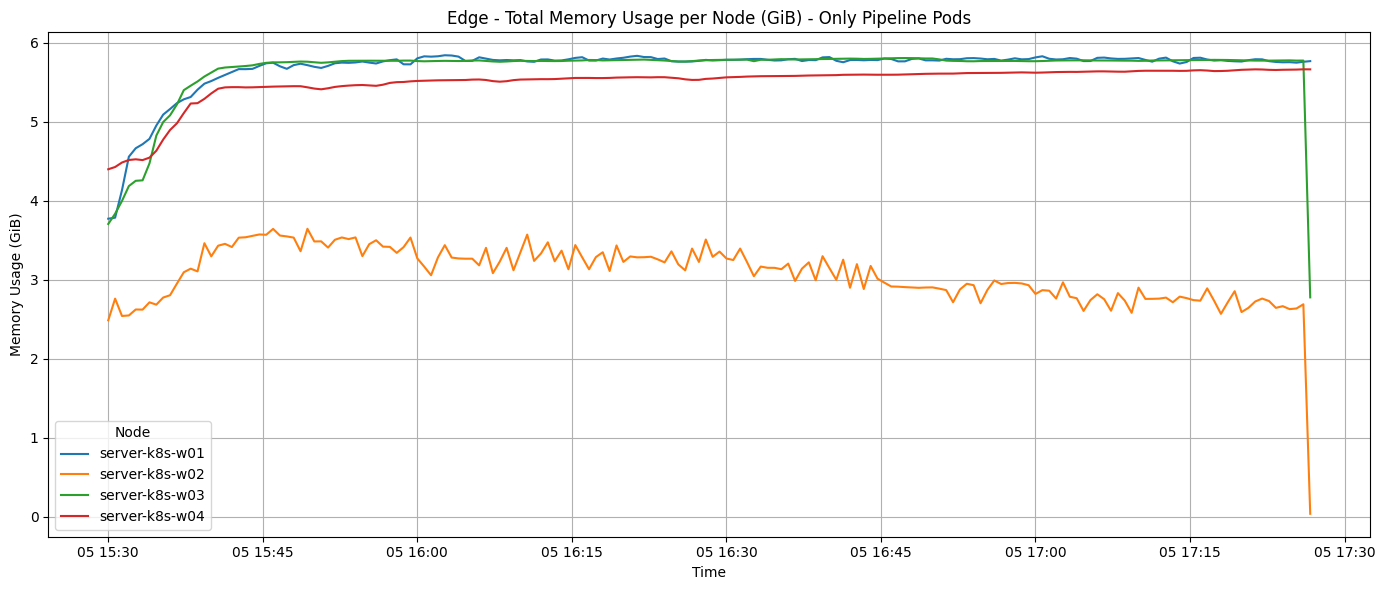

In [14]:
memory_chart_nodes(df_container_memory_usage_bytes_filtered, "Edge - Total Memory Usage per Node (GiB) - Only Pipeline Pods")

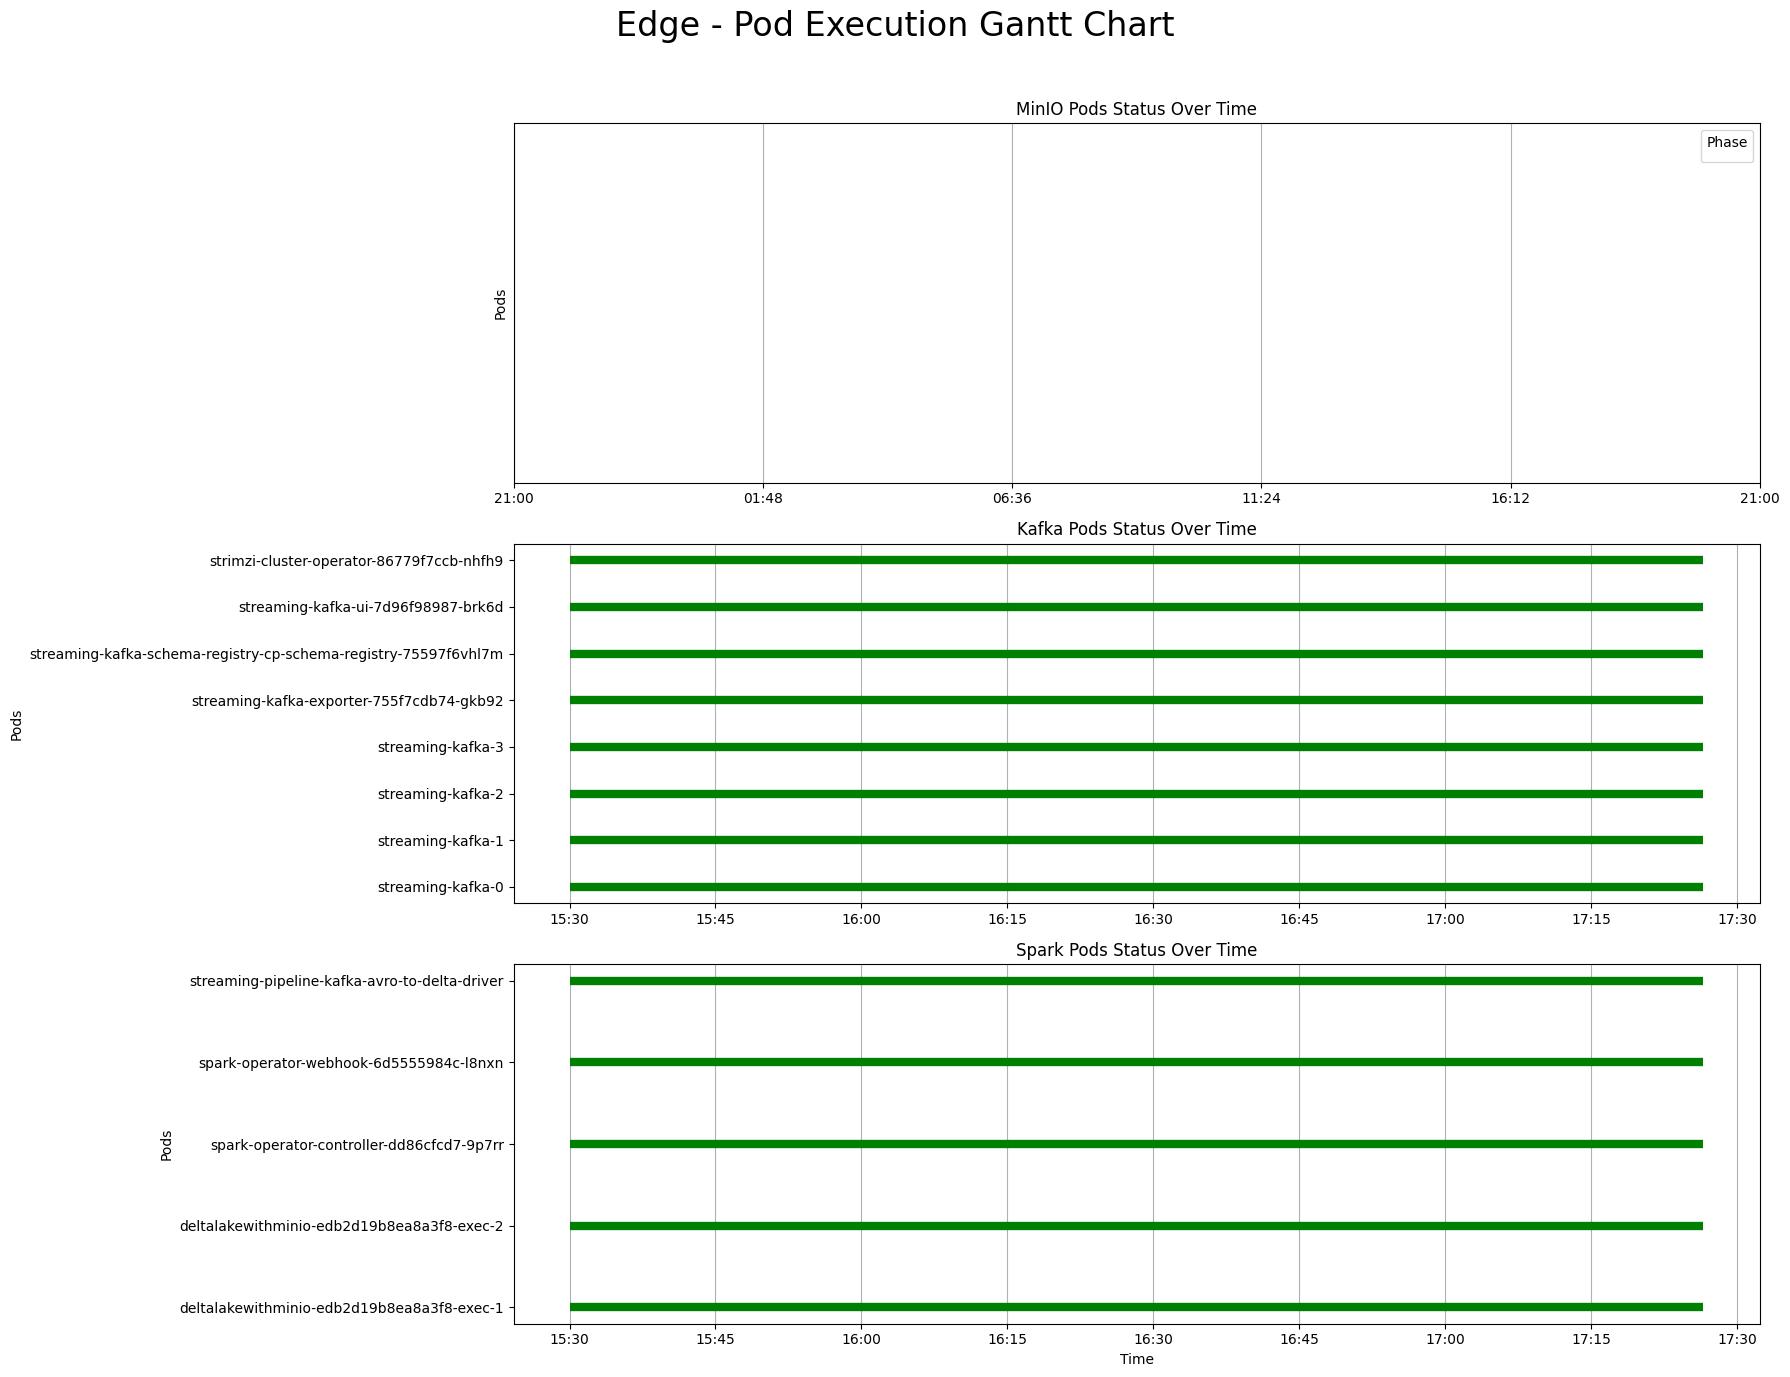

In [15]:
gantt_chart(df_kube_pod_status_phase, title="Edge - Pod Execution Gantt Chart")

/home/ark/streaming-pipeline/notebooks/charts.py:877: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(loc="upper right", fontsize="x-small", title="Pods")


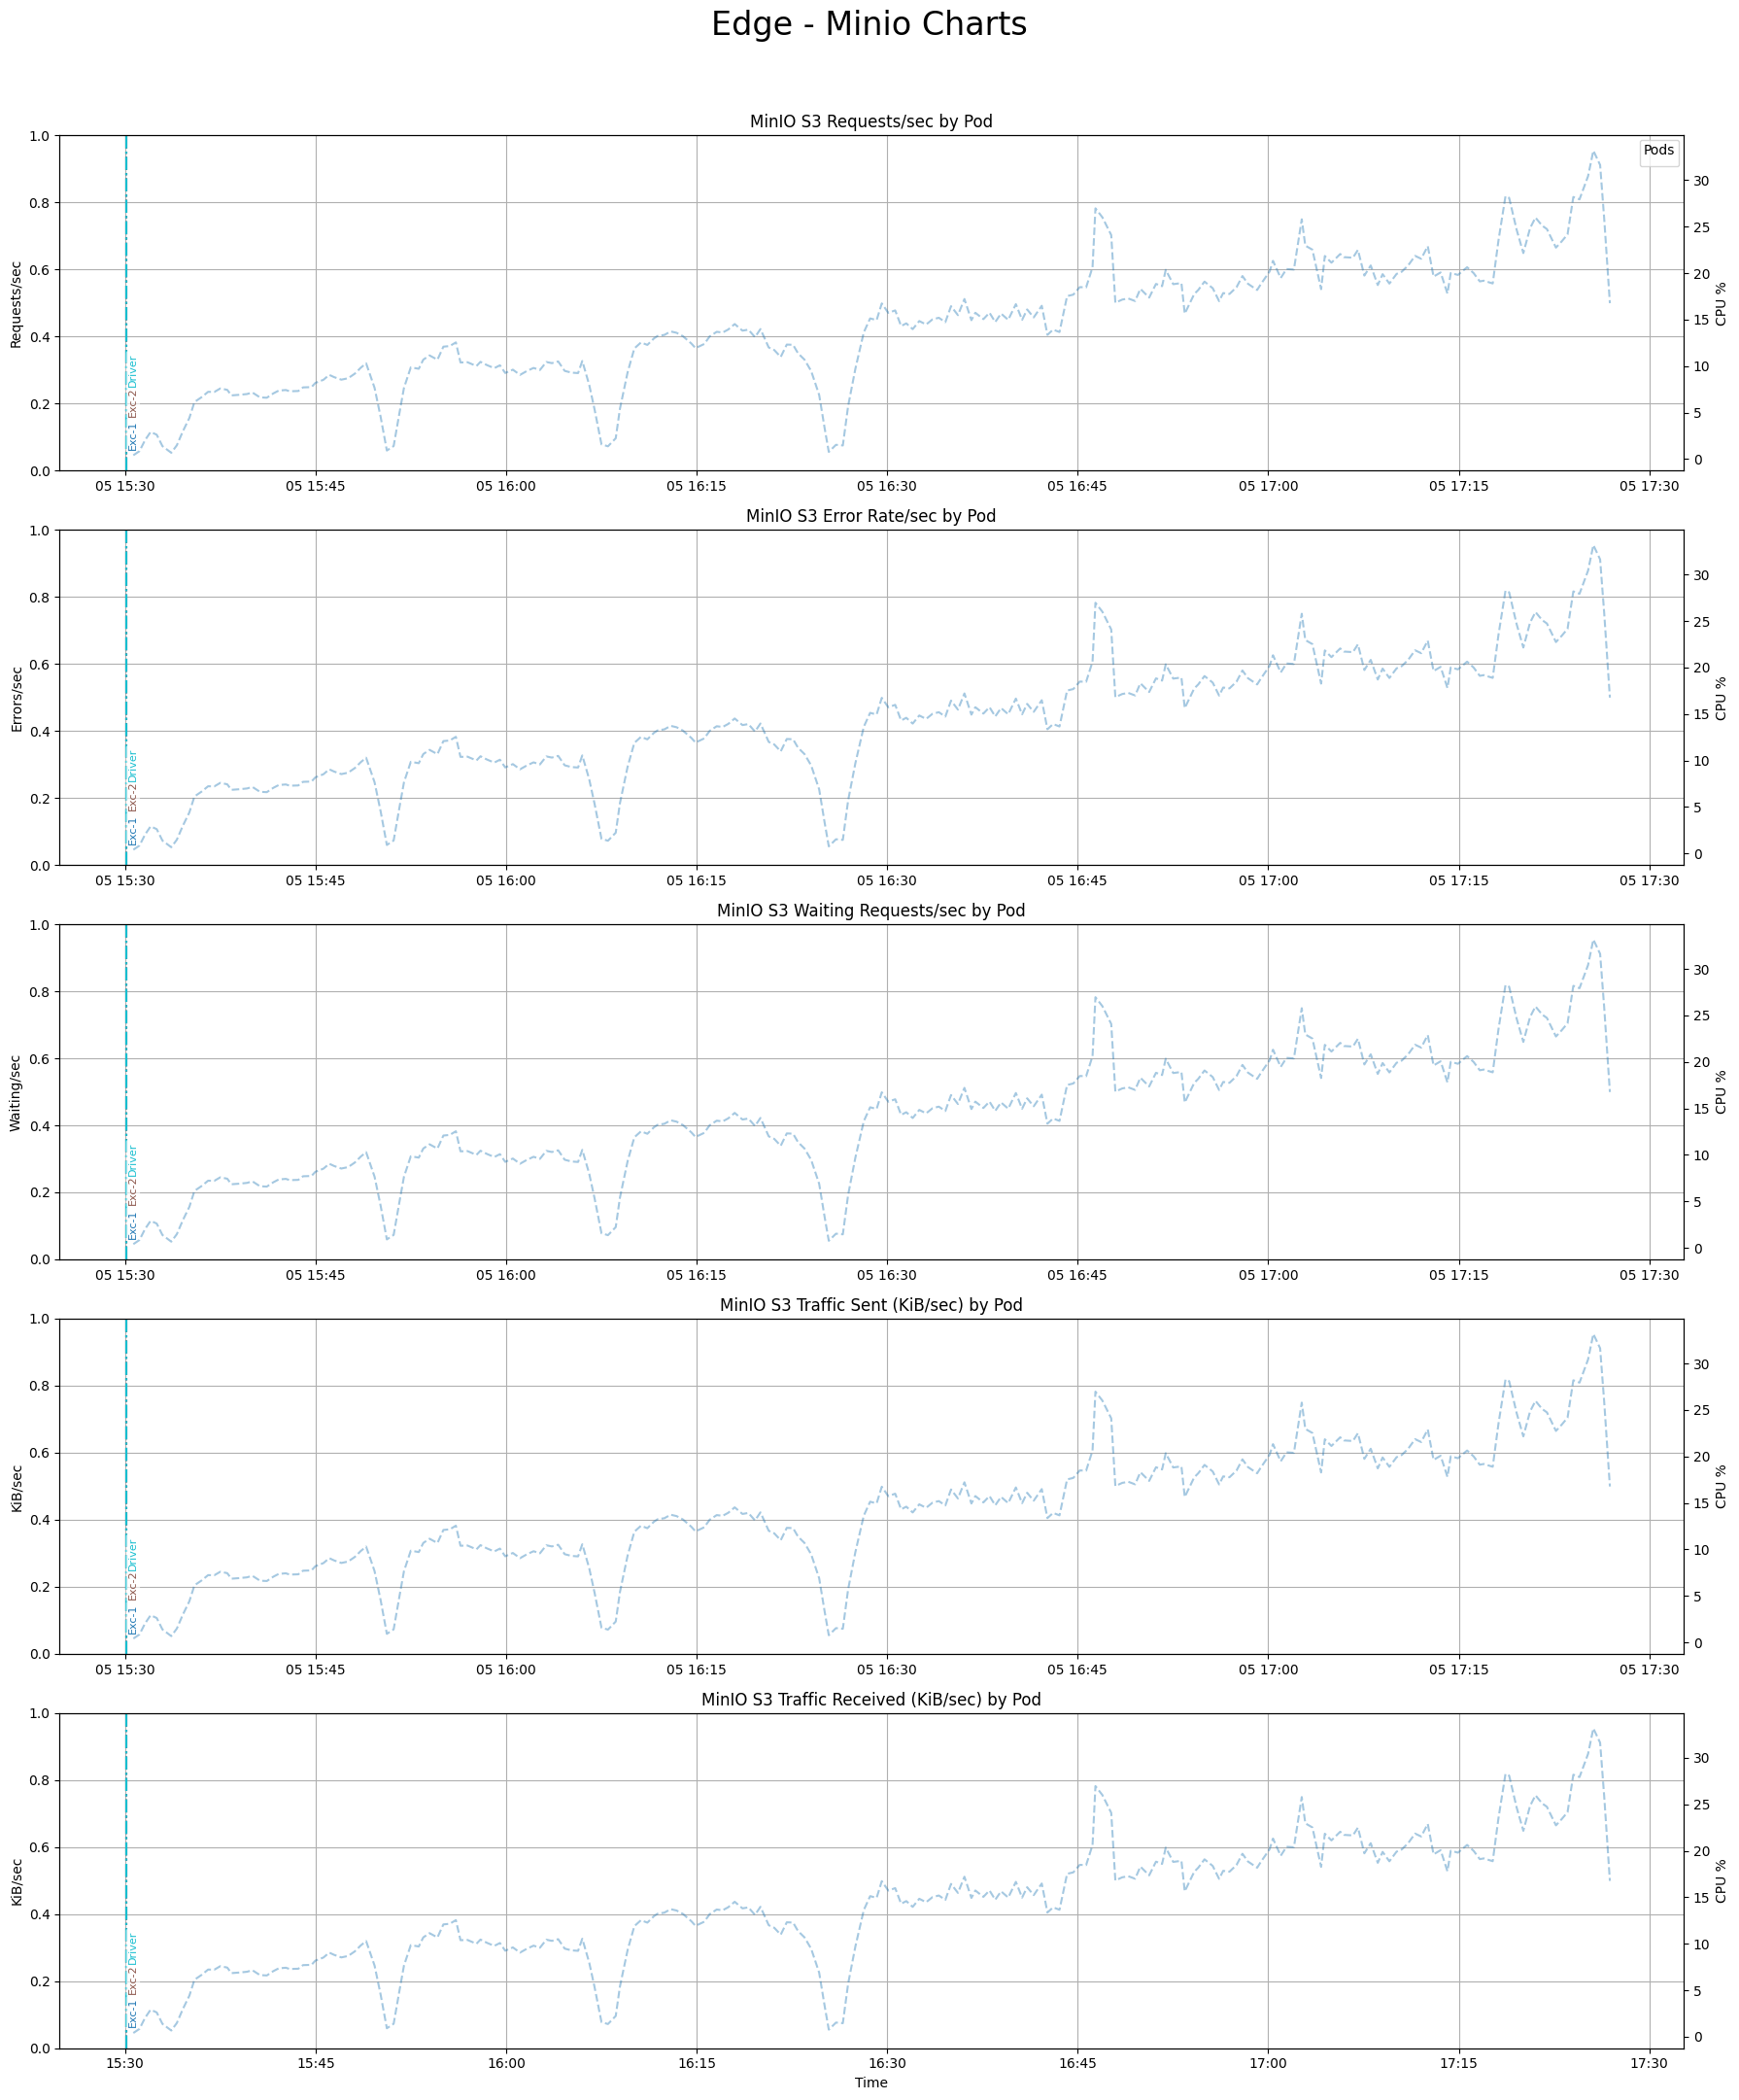

In [16]:
minio_charts(df_minio_total=df_minio_total, df_minio_errors=df_minio_errors, df_minio_waiting=df_minio_waiting, df_minio_sent_bytes=df_minio_sent_bytes, df_minio_received_bytes=df_minio_received_bytes, df_cpu=df_container_cpu_usage_seconds_total, df_status=df_kube_pod_status_phase, title="Edge - Minio Charts")

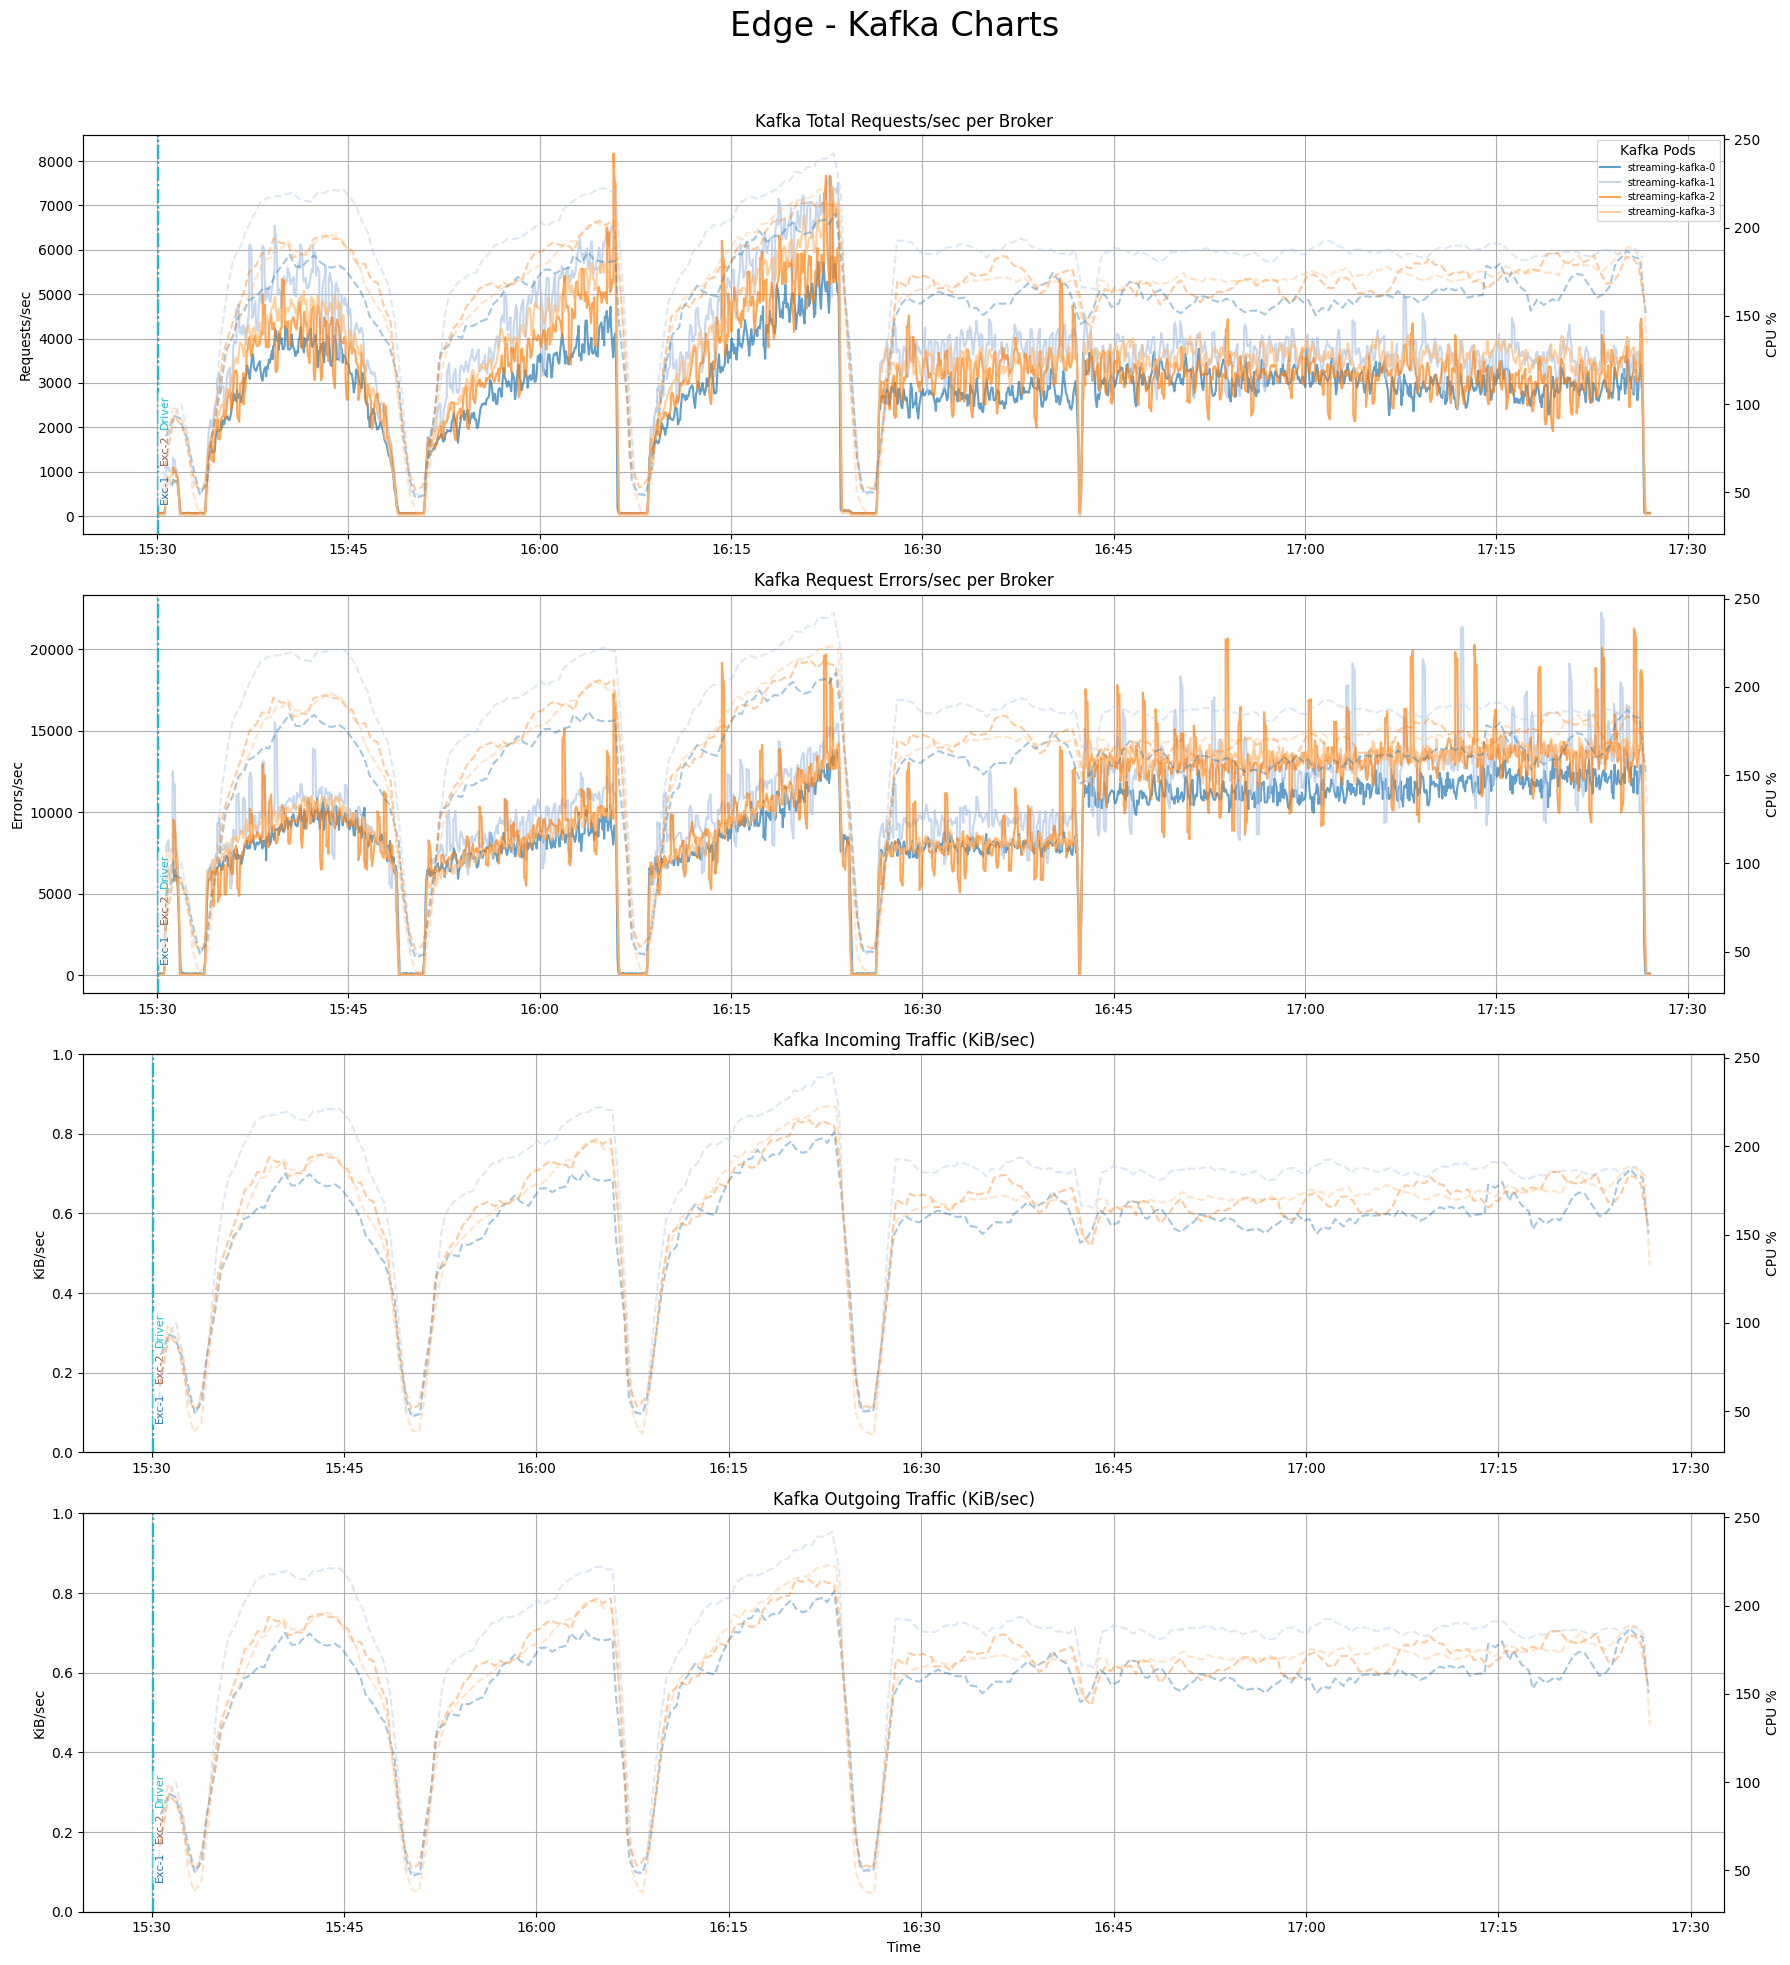

In [17]:
kafka_charts(kafka_bytes_in, kafka_bytes_out, kafka_requests, kafka_requests_errors, kafka_messages_in, df_container_cpu_usage_seconds_total, df_kube_pod_status_phase, title="Edge - Kafka Charts")

---

# Cloud Data

In [22]:
start_time = pd.Timestamp("2026-01-05 13:10:00").tz_localize("America/Sao_Paulo")
end_time = pd.Timestamp("2026-01-05 14:50:00").tz_localize("America/Sao_Paulo")

base_path = f"../../data/raw/{experiment_name}/{experiment_name}_cloud"

NODE_CPU_LIMITS = {
    'worker-pool-5d7mn': 400,
    'worker-pool-5d779': 400,
    'worker-pool-5d7m3': 400,
    'worker-pool-5d7m8': 400
}

memory = 8.192 * 1 # 8 GB

NODE_MEMORY_LIMITS = {
    'worker-pool-5d7mn': memory,
    'worker-pool-5d779': memory,
    'worker-pool-5d7m3': memory,
    'worker-pool-5d7m8': memory
}

df_container_cpu_usage_seconds_total = pd.read_parquet(base_path + "/container_cpu_usage_seconds_total.parquet")
df_container_memory_usage_bytes = pd.read_parquet(base_path + "/container_memory_usage_bytes.parquet")
df_kube_pod_status_phase = pd.read_parquet(base_path + "/kube_pod_status_phase.parquet")

kafka_bytes_in = pd.read_parquet(base_path + "/kafka_server_brokertopicmetrics_bytesin_total.parquet")
kafka_bytes_out = pd.read_parquet(base_path + "/kafka_server_brokertopicmetrics_bytesout_total.parquet")
kafka_messages_in = pd.read_parquet(base_path + "/kafka_server_brokertopicmetrics_messagesin_total.parquet")
kafka_requests = pd.read_parquet(base_path + "/kafka_network_requestmetrics_requests_total.parquet")
kafka_requests_errors = pd.read_parquet(base_path + "/kafka_network_requestmetrics_errors_total.parquet")

# === Load all MinIO metric CSVs ===
df_minio_incoming = time_filter(pd.read_parquet(base_path + '/minio_s3_requests_incoming_total.parquet').reset_index(), start_time, end_time)
df_minio_total = time_filter(pd.read_parquet(base_path + '/minio_s3_requests_total.parquet').reset_index(), start_time, end_time)
df_minio_waiting = time_filter(pd.read_parquet(base_path + '/minio_s3_requests_waiting_total.parquet').reset_index(), start_time, end_time)
df_minio_errors = time_filter(pd.read_parquet(base_path + '/minio_s3_requests_errors_total.parquet').reset_index(), start_time, end_time)
df_minio_sent_bytes = time_filter(pd.read_parquet(base_path + '/minio_s3_traffic_sent_bytes.parquet').reset_index(), start_time, end_time)
df_minio_received_bytes = time_filter(pd.read_parquet(base_path + '/minio_s3_traffic_received_bytes.parquet').reset_index(), start_time, end_time)

df_container_cpu_usage_seconds_total = df_container_cpu_usage_seconds_total.reset_index()
df_container_memory_usage_bytes = df_container_memory_usage_bytes.reset_index()
df_kube_pod_status_phase = df_kube_pod_status_phase.reset_index()

kafka_bytes_in = kafka_bytes_in.reset_index()
kafka_bytes_out = kafka_bytes_out.reset_index()
kafka_messages_in = kafka_messages_in.reset_index()
kafka_requests = kafka_requests.reset_index()
kafka_requests_errors = kafka_requests_errors.reset_index()

df_container_cpu_usage_seconds_total = time_filter(df_container_cpu_usage_seconds_total, start_time, end_time)
df_container_memory_usage_bytes = time_filter(df_container_memory_usage_bytes, start_time, end_time)
df_kube_pod_status_phase = time_filter(df_kube_pod_status_phase, start_time, end_time)

kafka_bytes_in = time_filter(kafka_bytes_in, start_time, end_time)
kafka_bytes_out = time_filter(kafka_bytes_out, start_time, end_time)
kafka_messages_in = time_filter(kafka_messages_in, start_time, end_time)
kafka_requests = time_filter(kafka_requests, start_time, end_time)
kafka_requests_errors = time_filter(kafka_requests_errors, start_time, end_time)

selected_pods = get_selected_pods(df_kube_pod_status_phase)

df_kube_pod_status_phase = df_kube_pod_status_phase[df_kube_pod_status_phase["pod"].isin(selected_pods)]
df_container_cpu_usage_seconds_total_filtered = df_container_cpu_usage_seconds_total[df_container_cpu_usage_seconds_total["pod"].isin(selected_pods)]
df_container_memory_usage_bytes_filtered = df_container_memory_usage_bytes[df_container_memory_usage_bytes["pod"].isin(selected_pods)]

In [23]:
df_container_cpu_usage_seconds_total["node"].unique()

array(['worker-pool-5d7mn', 'worker-pool-5d779', 'worker-pool-5d7m3',
       'worker-pool-5d7m8'], dtype=object)

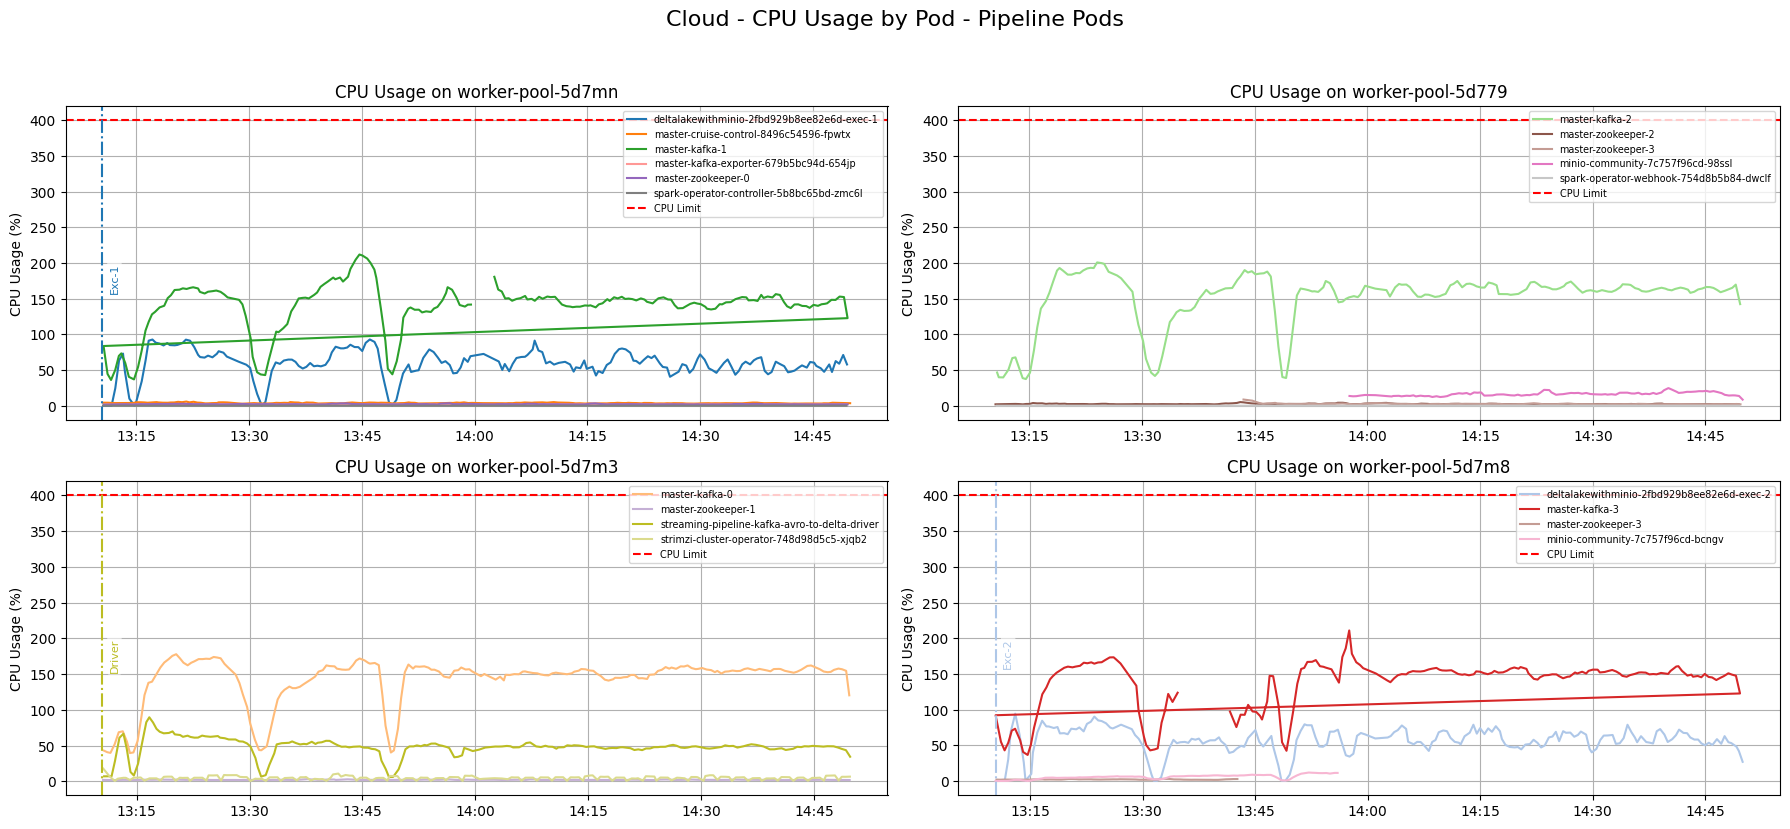

In [24]:
cpu_chart(df_container_cpu_usage_seconds_total_filtered, df_kube_pod_status_phase, title="Cloud - CPU Usage by Pod - Pipeline Pods", node_cpu_limits=NODE_CPU_LIMITS)

/home/ark/streaming-pipeline/notebooks/charts.py:214: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .mean(numeric_only=True)  # Ensures only numeric values are averaged


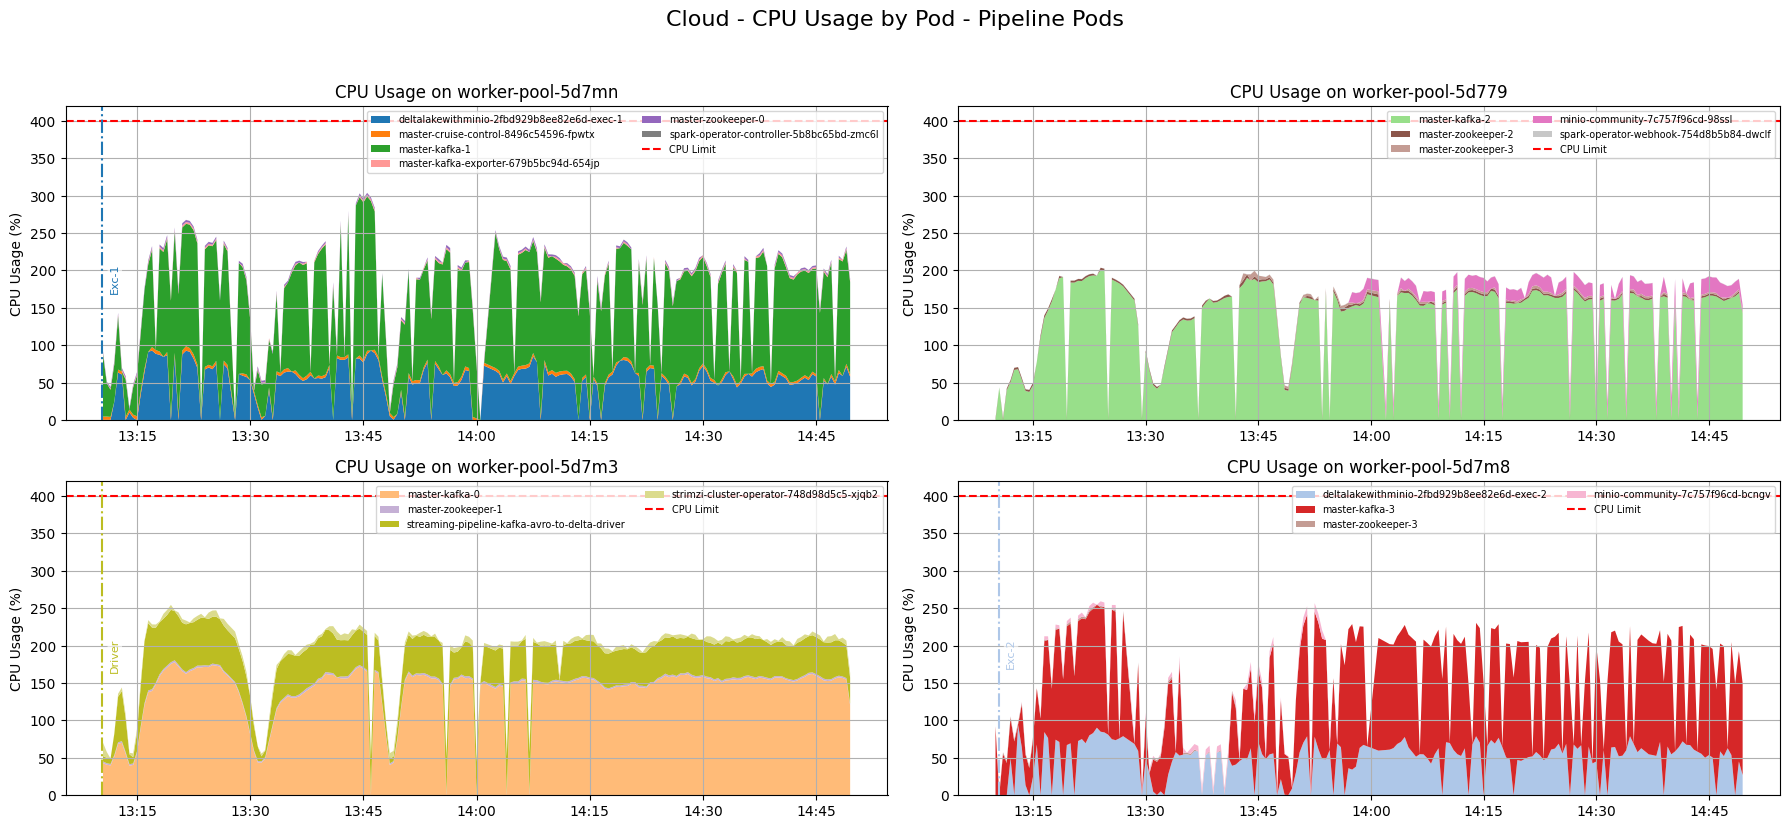

In [25]:
cpu_chart_stacked(df_container_cpu_usage_seconds_total_filtered, df_kube_pod_status_phase, title="Cloud - CPU Usage by Pod - Pipeline Pods", node_cpu_limits=NODE_CPU_LIMITS)

/home/ark/streaming-pipeline/notebooks/charts.py:214: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .mean(numeric_only=True)  # Ensures only numeric values are averaged


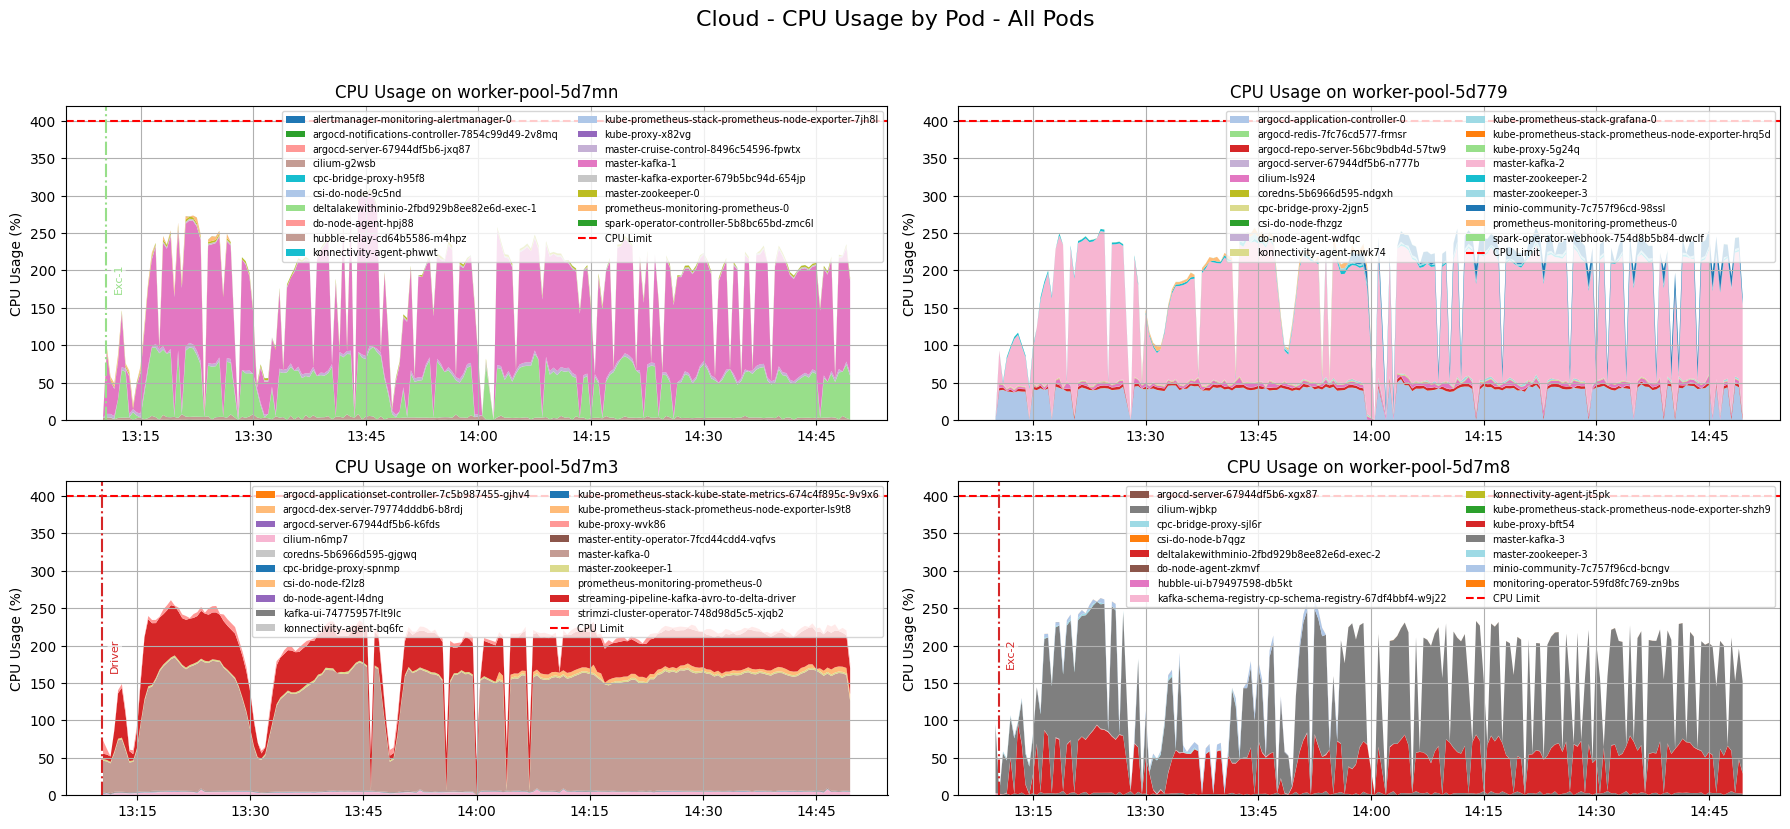

In [26]:
cpu_chart_stacked(df_container_cpu_usage_seconds_total, df_kube_pod_status_phase, title="Cloud - CPU Usage by Pod - All Pods", node_cpu_limits=NODE_CPU_LIMITS)

/home/ark/streaming-pipeline/notebooks/charts.py:307: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .mean(numeric_only=True)


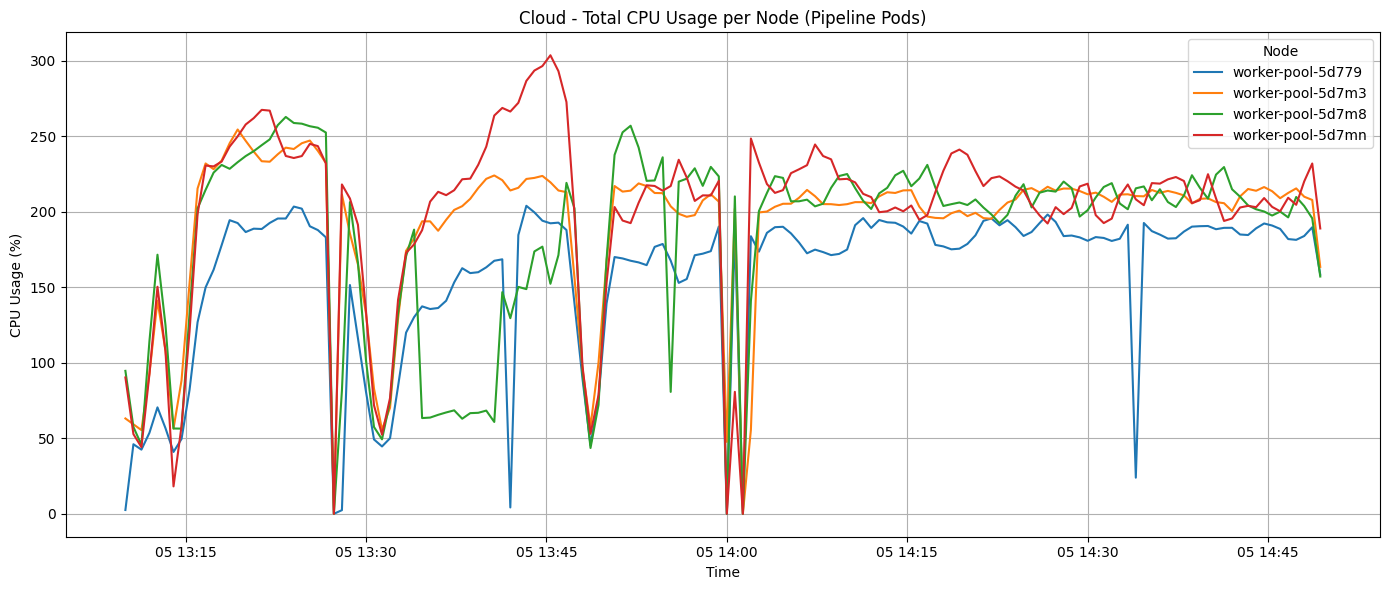

In [27]:
cpu_chart_nodes(df_container_cpu_usage_seconds_total_filtered, "Cloud - Total CPU Usage per Node (Pipeline Pods)")

/home/ark/streaming-pipeline/notebooks/charts.py:307: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .mean(numeric_only=True)


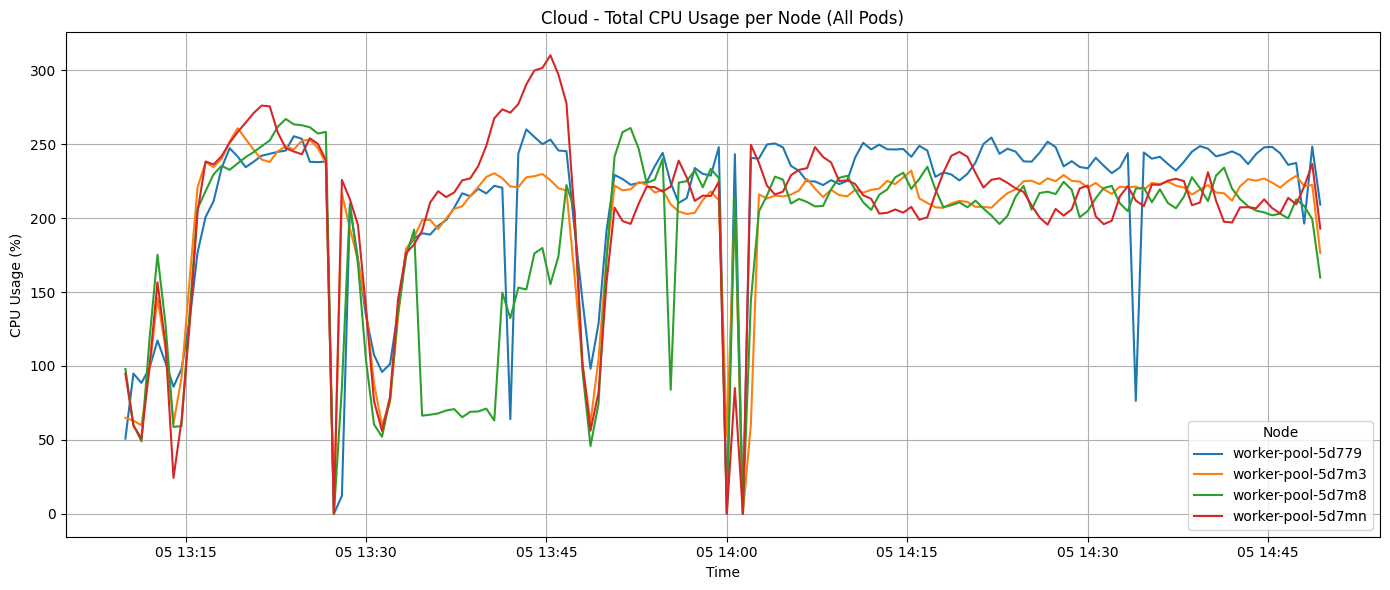

In [28]:
cpu_chart_nodes(df_container_cpu_usage_seconds_total, "Cloud - Total CPU Usage per Node (All Pods)")

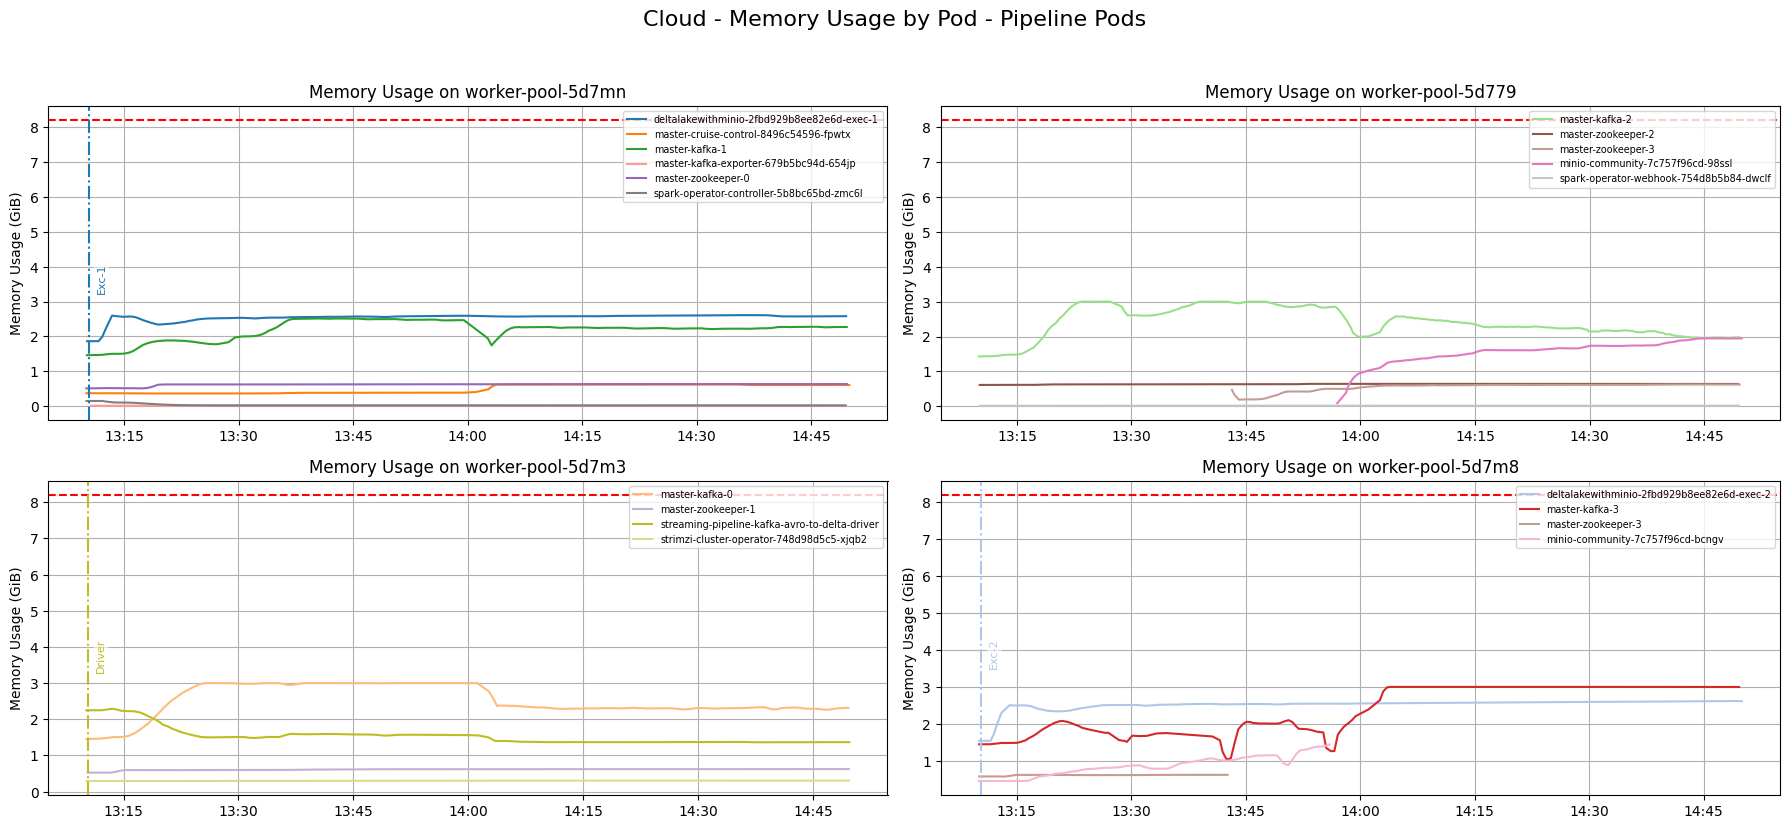

In [29]:
memory_chart(df_container_memory_usage_bytes_filtered, df_kube_pod_status_phase, title="Cloud - Memory Usage by Pod - Pipeline Pods", node_memory_limits=NODE_MEMORY_LIMITS)

/home/ark/streaming-pipeline/notebooks/charts.py:442: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .mean(numeric_only=True)


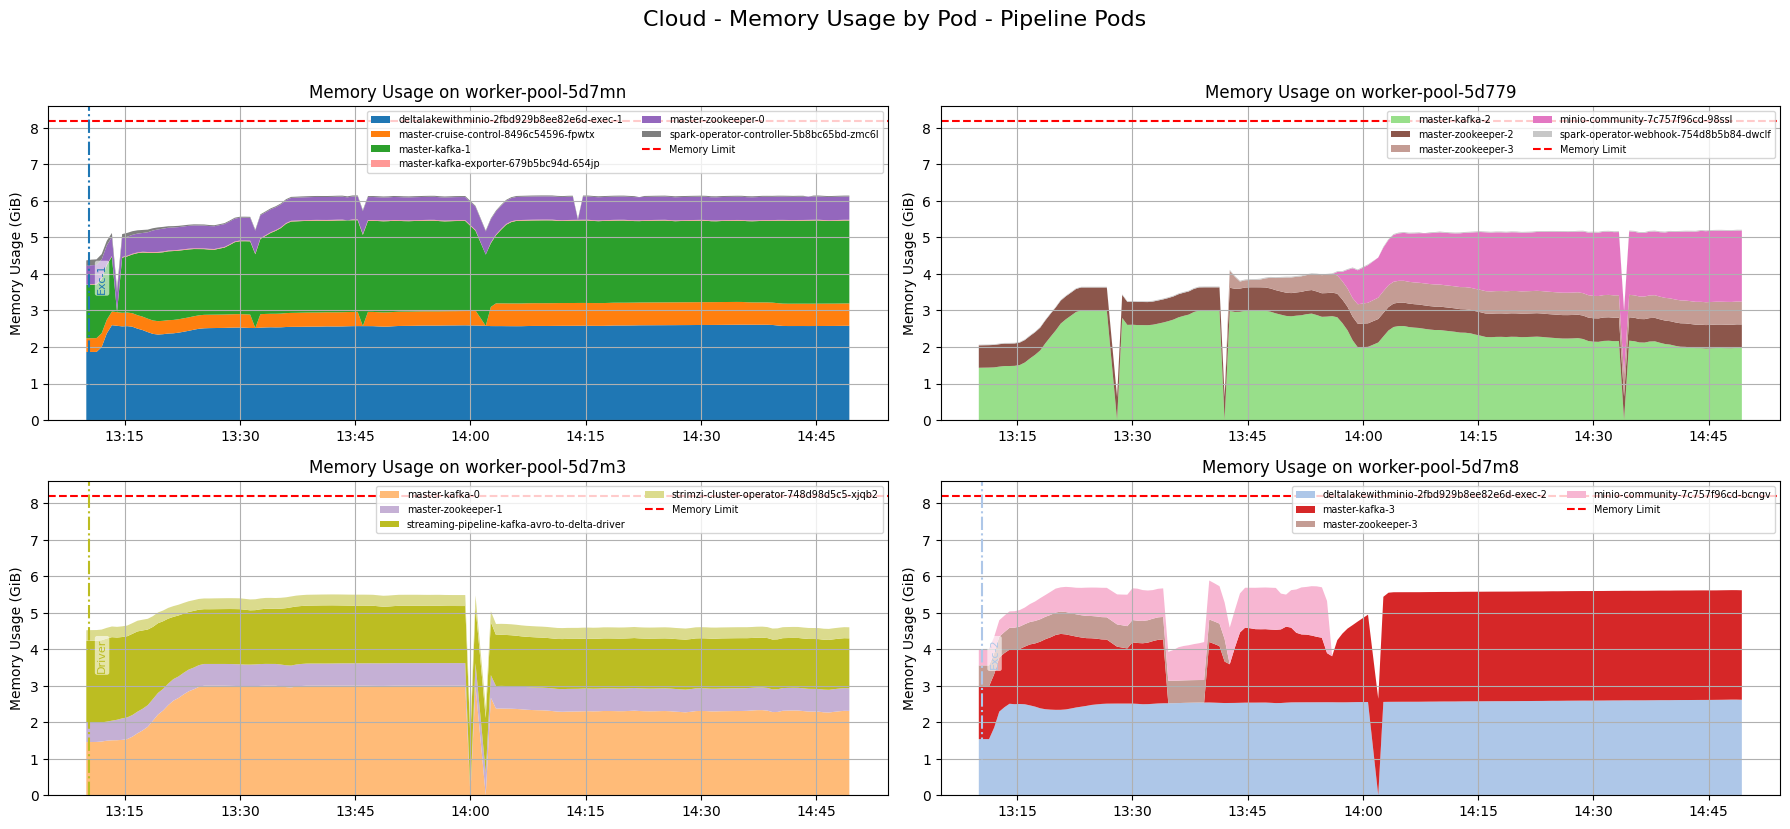

In [30]:
memory_chart_stacked(df_container_memory_usage_bytes_filtered, df_kube_pod_status_phase, title="Cloud - Memory Usage by Pod - Pipeline Pods", node_memory_limits=NODE_MEMORY_LIMITS)

/home/ark/streaming-pipeline/notebooks/charts.py:442: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .mean(numeric_only=True)


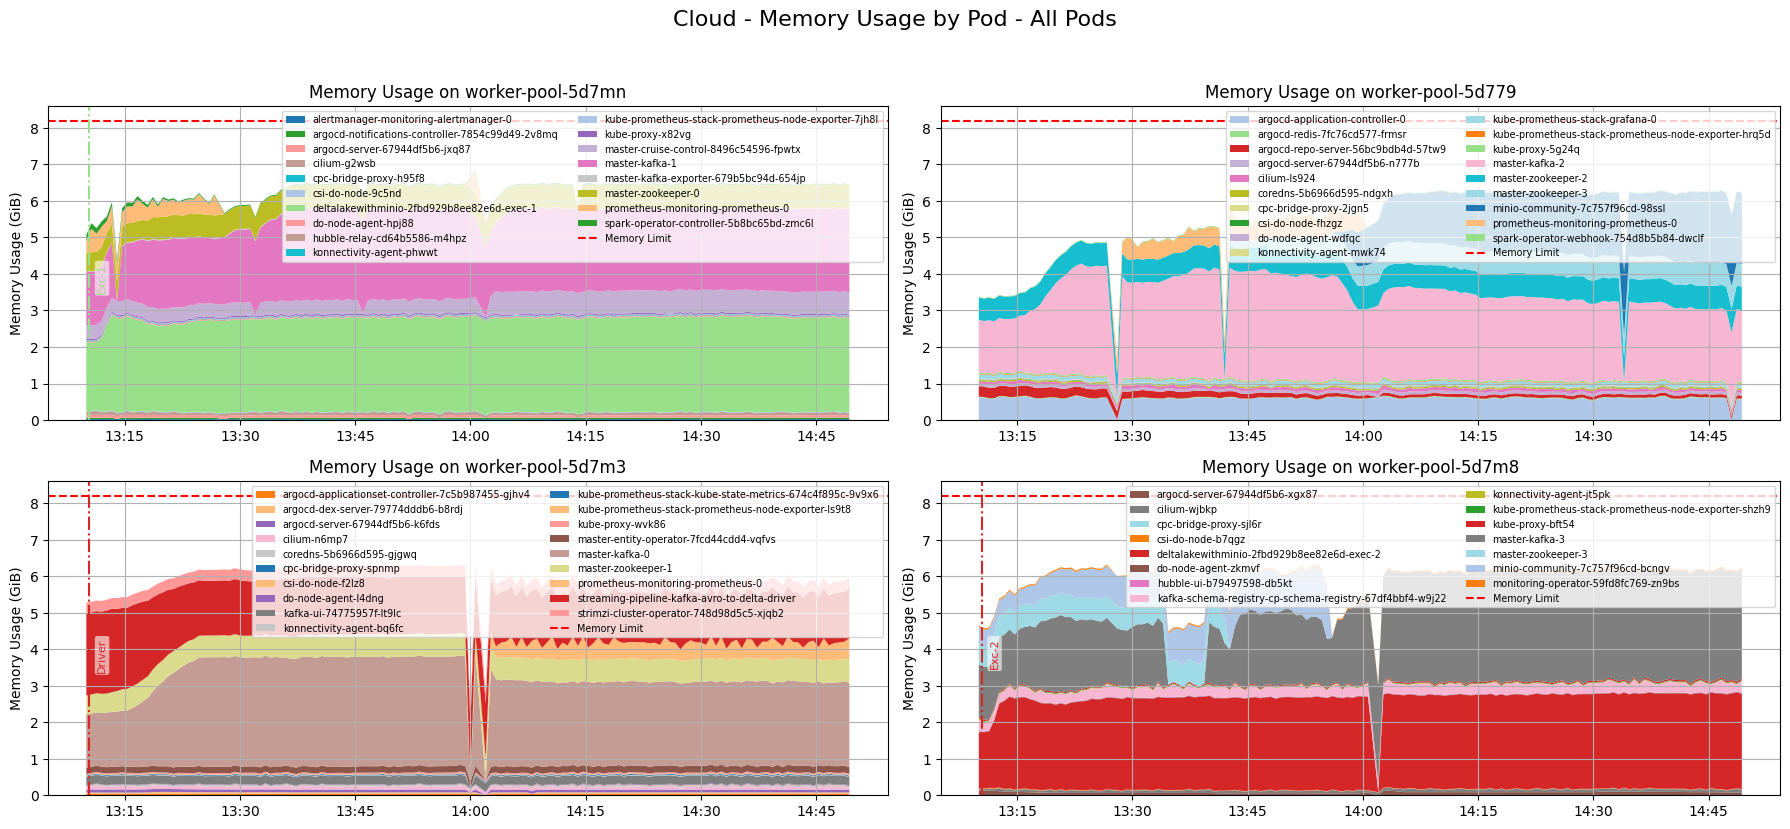

In [31]:
memory_chart_stacked(df_container_memory_usage_bytes, df_kube_pod_status_phase, title="Cloud - Memory Usage by Pod - All Pods", node_memory_limits=NODE_MEMORY_LIMITS )

/home/ark/streaming-pipeline/notebooks/charts.py:536: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .mean(numeric_only=True)


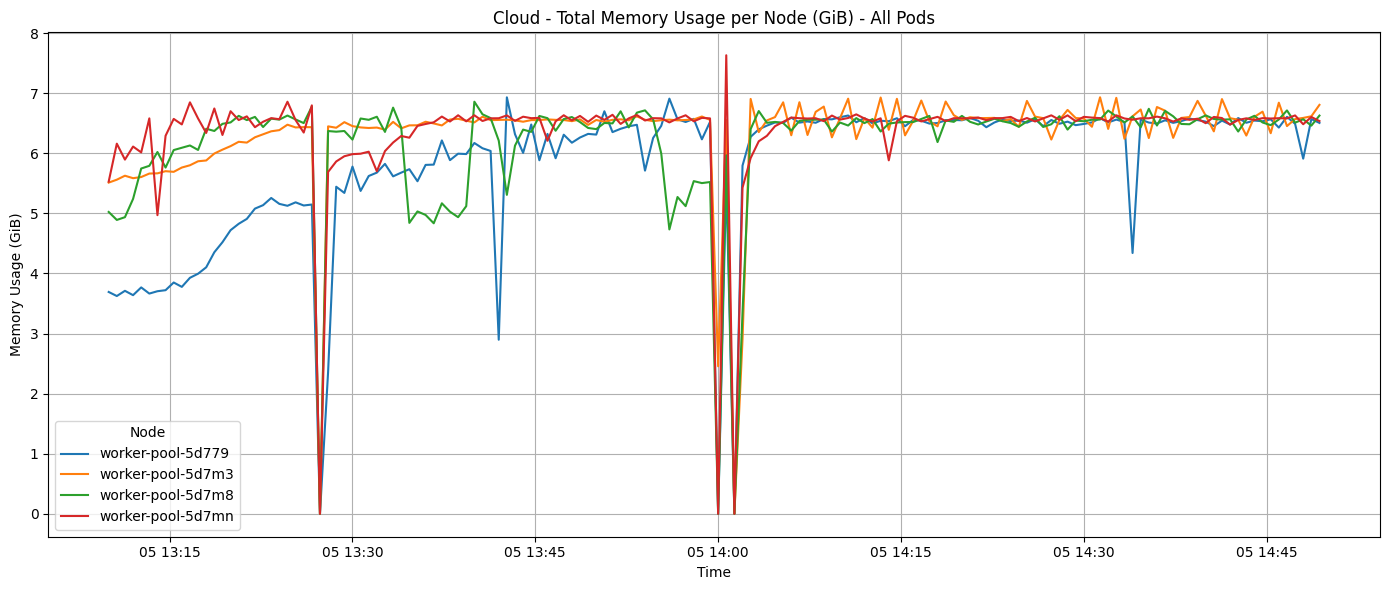

In [32]:
memory_chart_nodes(df_container_memory_usage_bytes, "Cloud - Total Memory Usage per Node (GiB) - All Pods")

/home/ark/streaming-pipeline/notebooks/charts.py:536: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .mean(numeric_only=True)


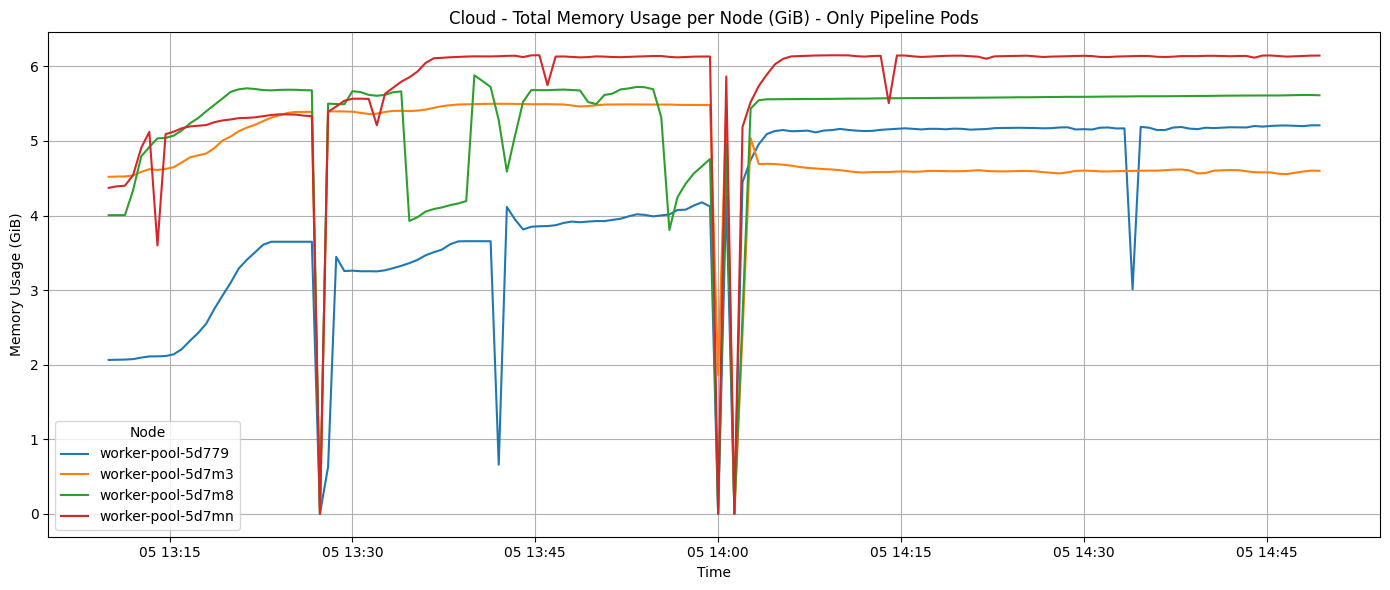

In [33]:
memory_chart_nodes(df_container_memory_usage_bytes_filtered, "Cloud - Total Memory Usage per Node (GiB) - Only Pipeline Pods")

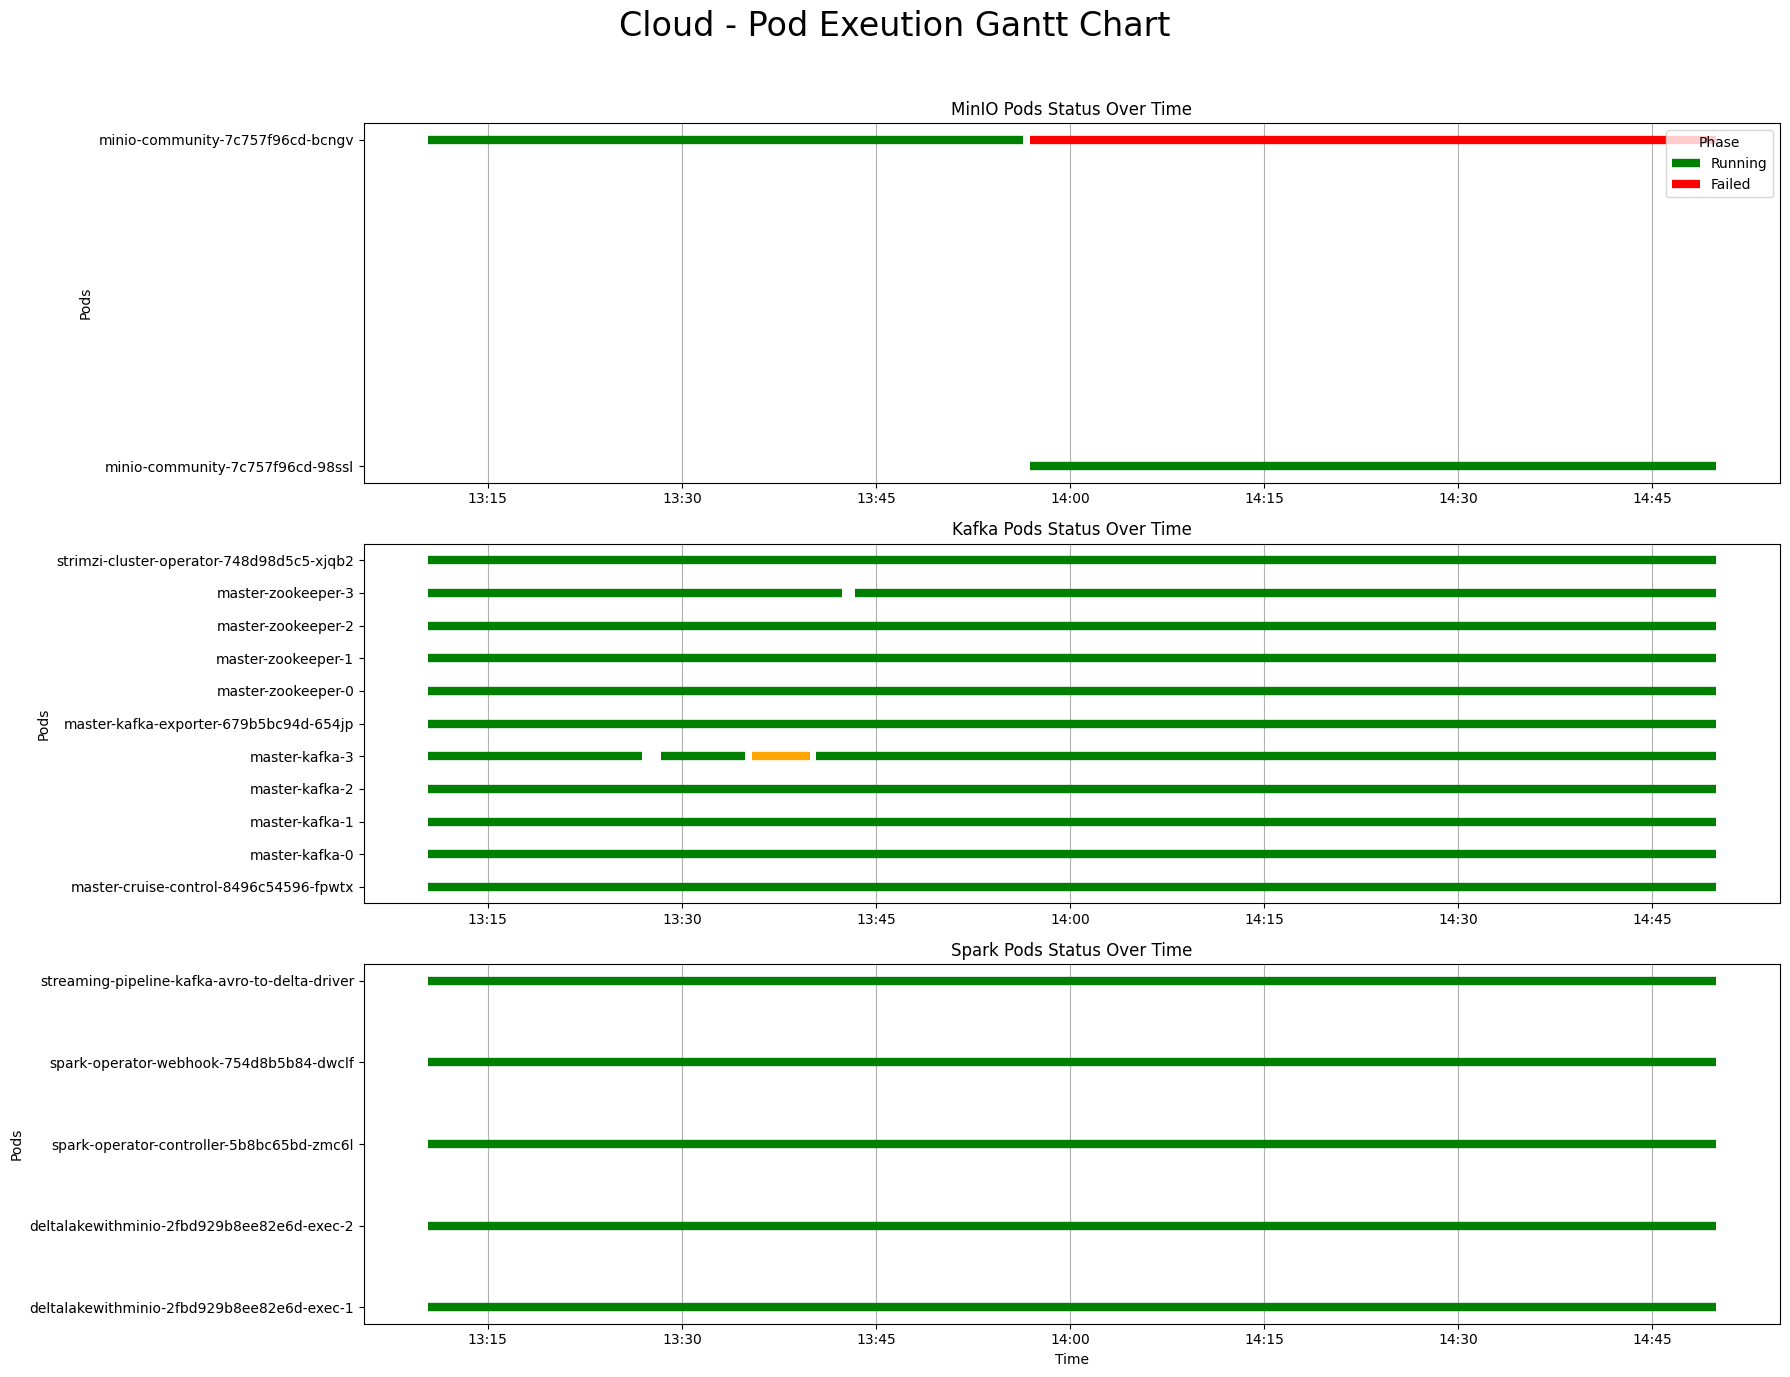

In [34]:
gantt_chart(df_kube_pod_status_phase, title="Cloud - Pod Exeution Gantt Chart")

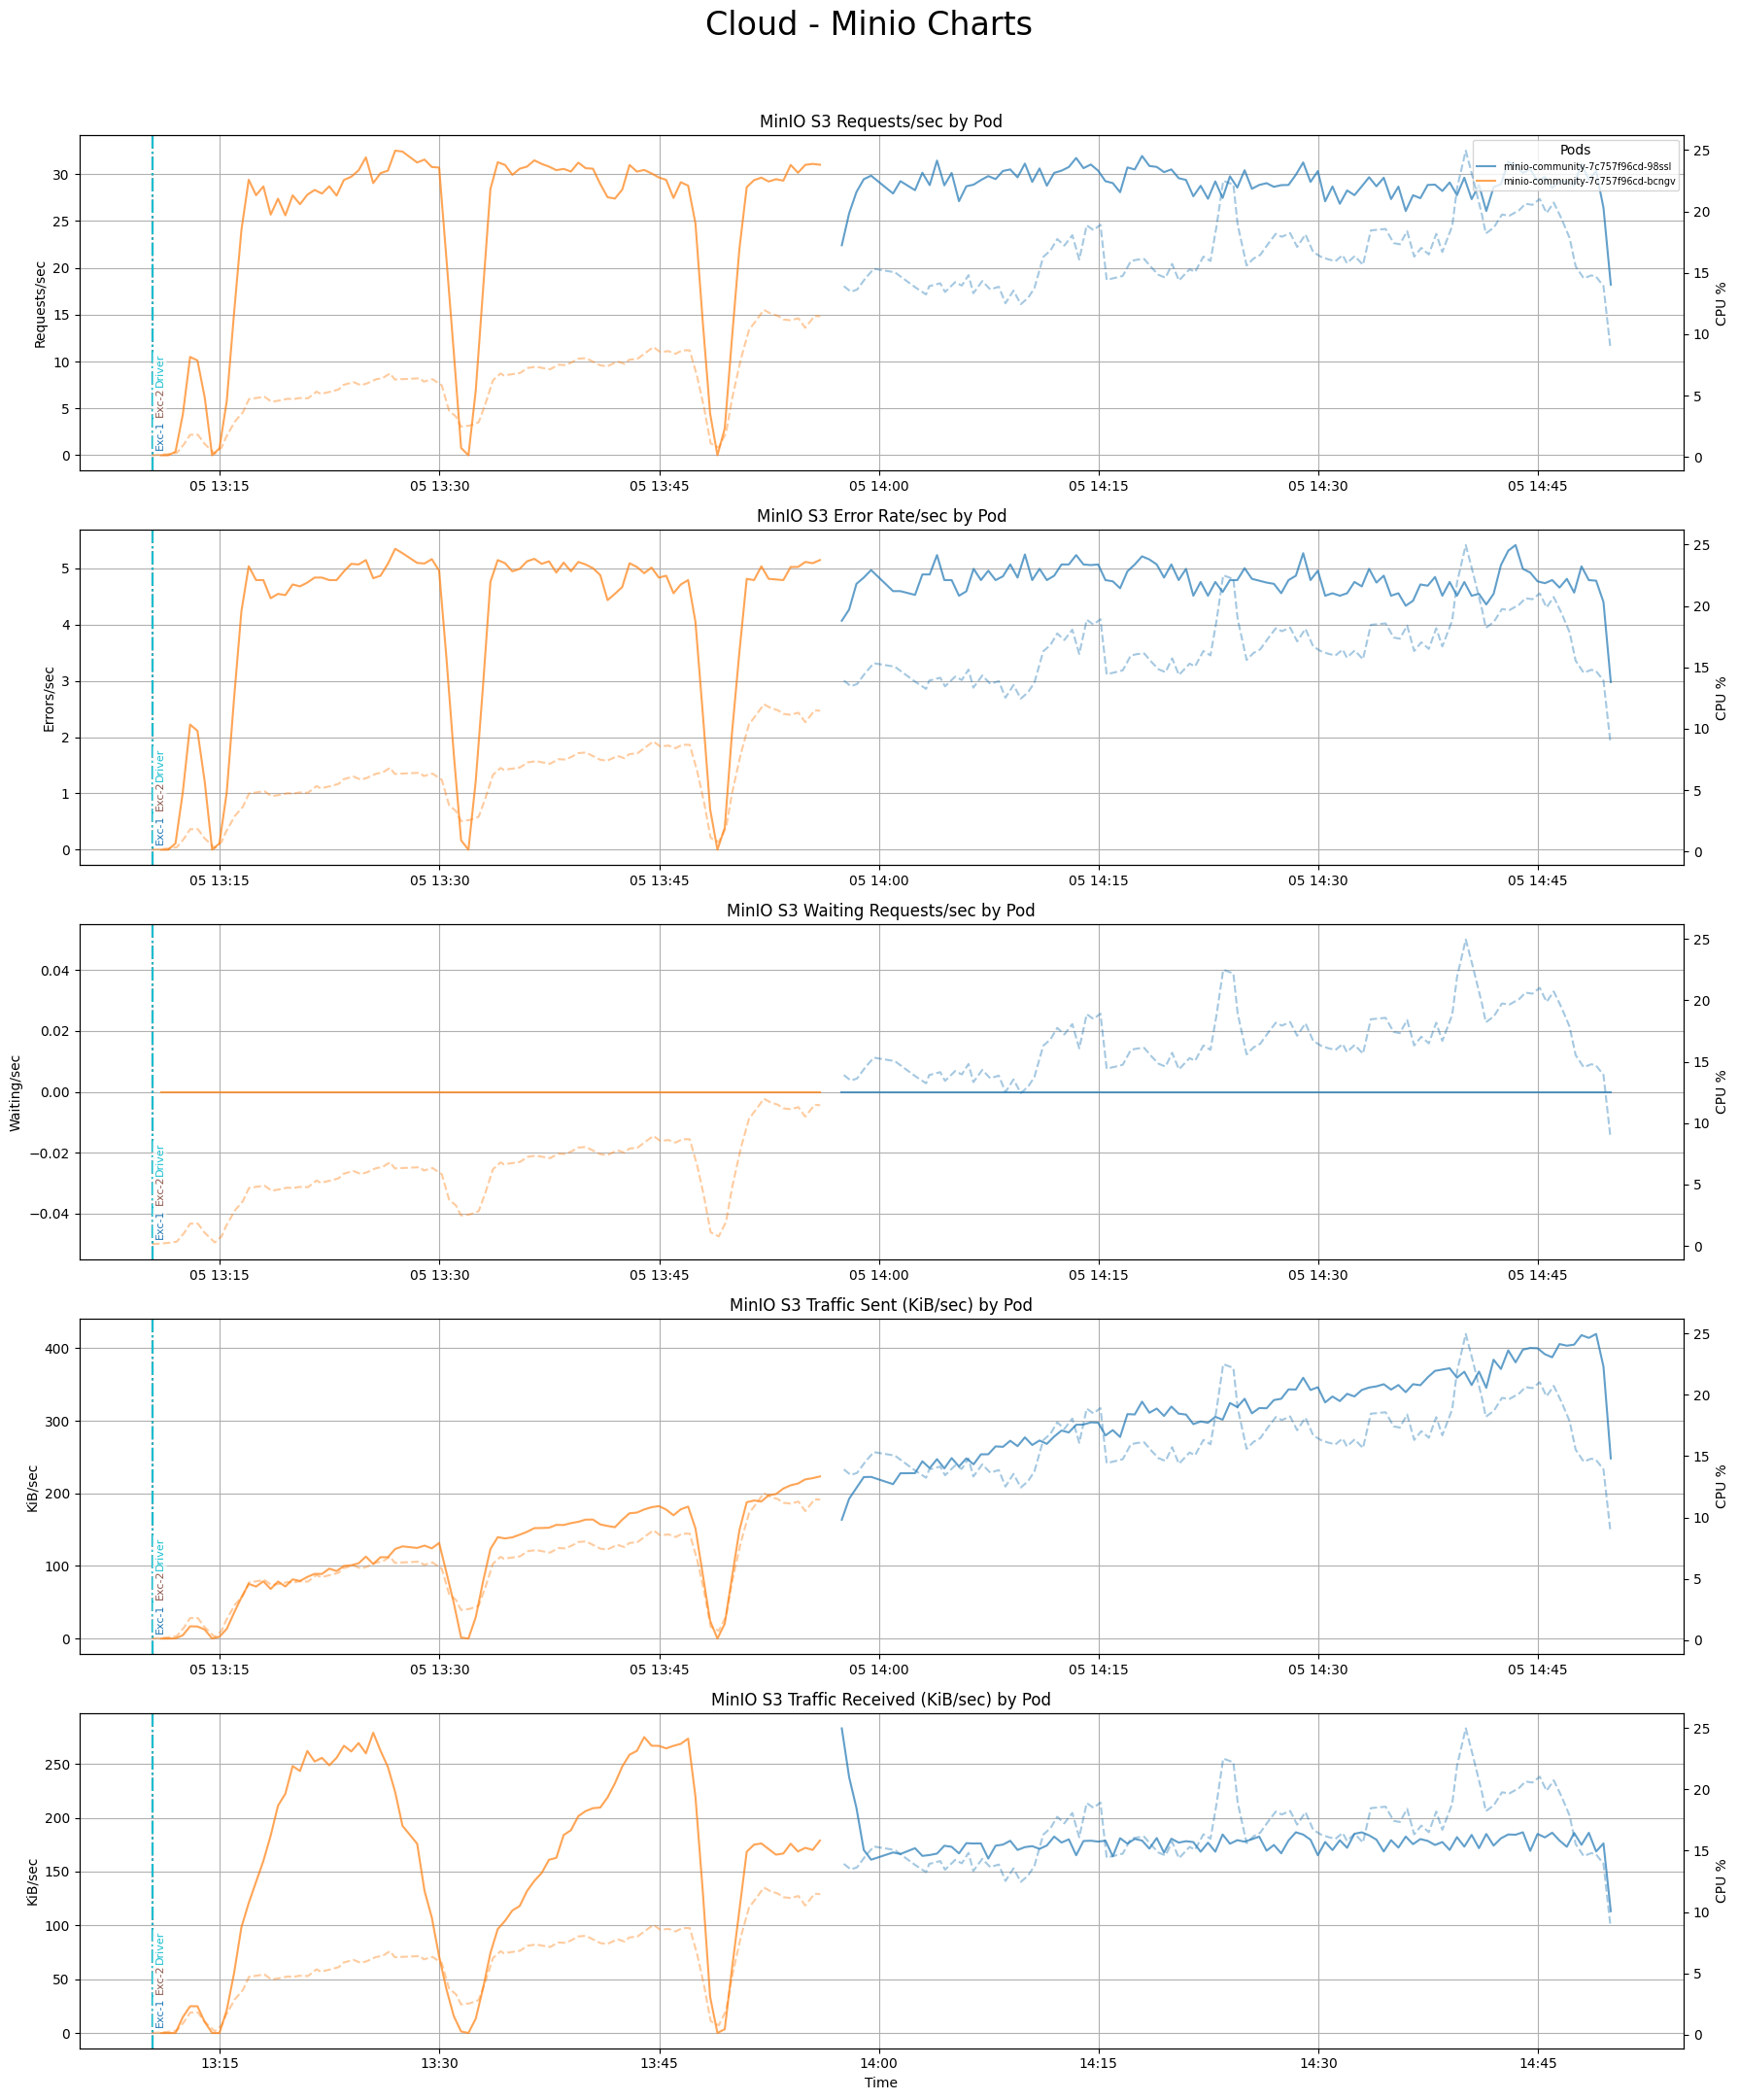

In [35]:
minio_charts(df_minio_total=df_minio_total, df_minio_errors=df_minio_errors, df_minio_waiting=df_minio_waiting, df_minio_sent_bytes=df_minio_sent_bytes, df_minio_received_bytes=df_minio_received_bytes, df_cpu=df_container_cpu_usage_seconds_total, df_status=df_kube_pod_status_phase, title="Cloud - Minio Charts")

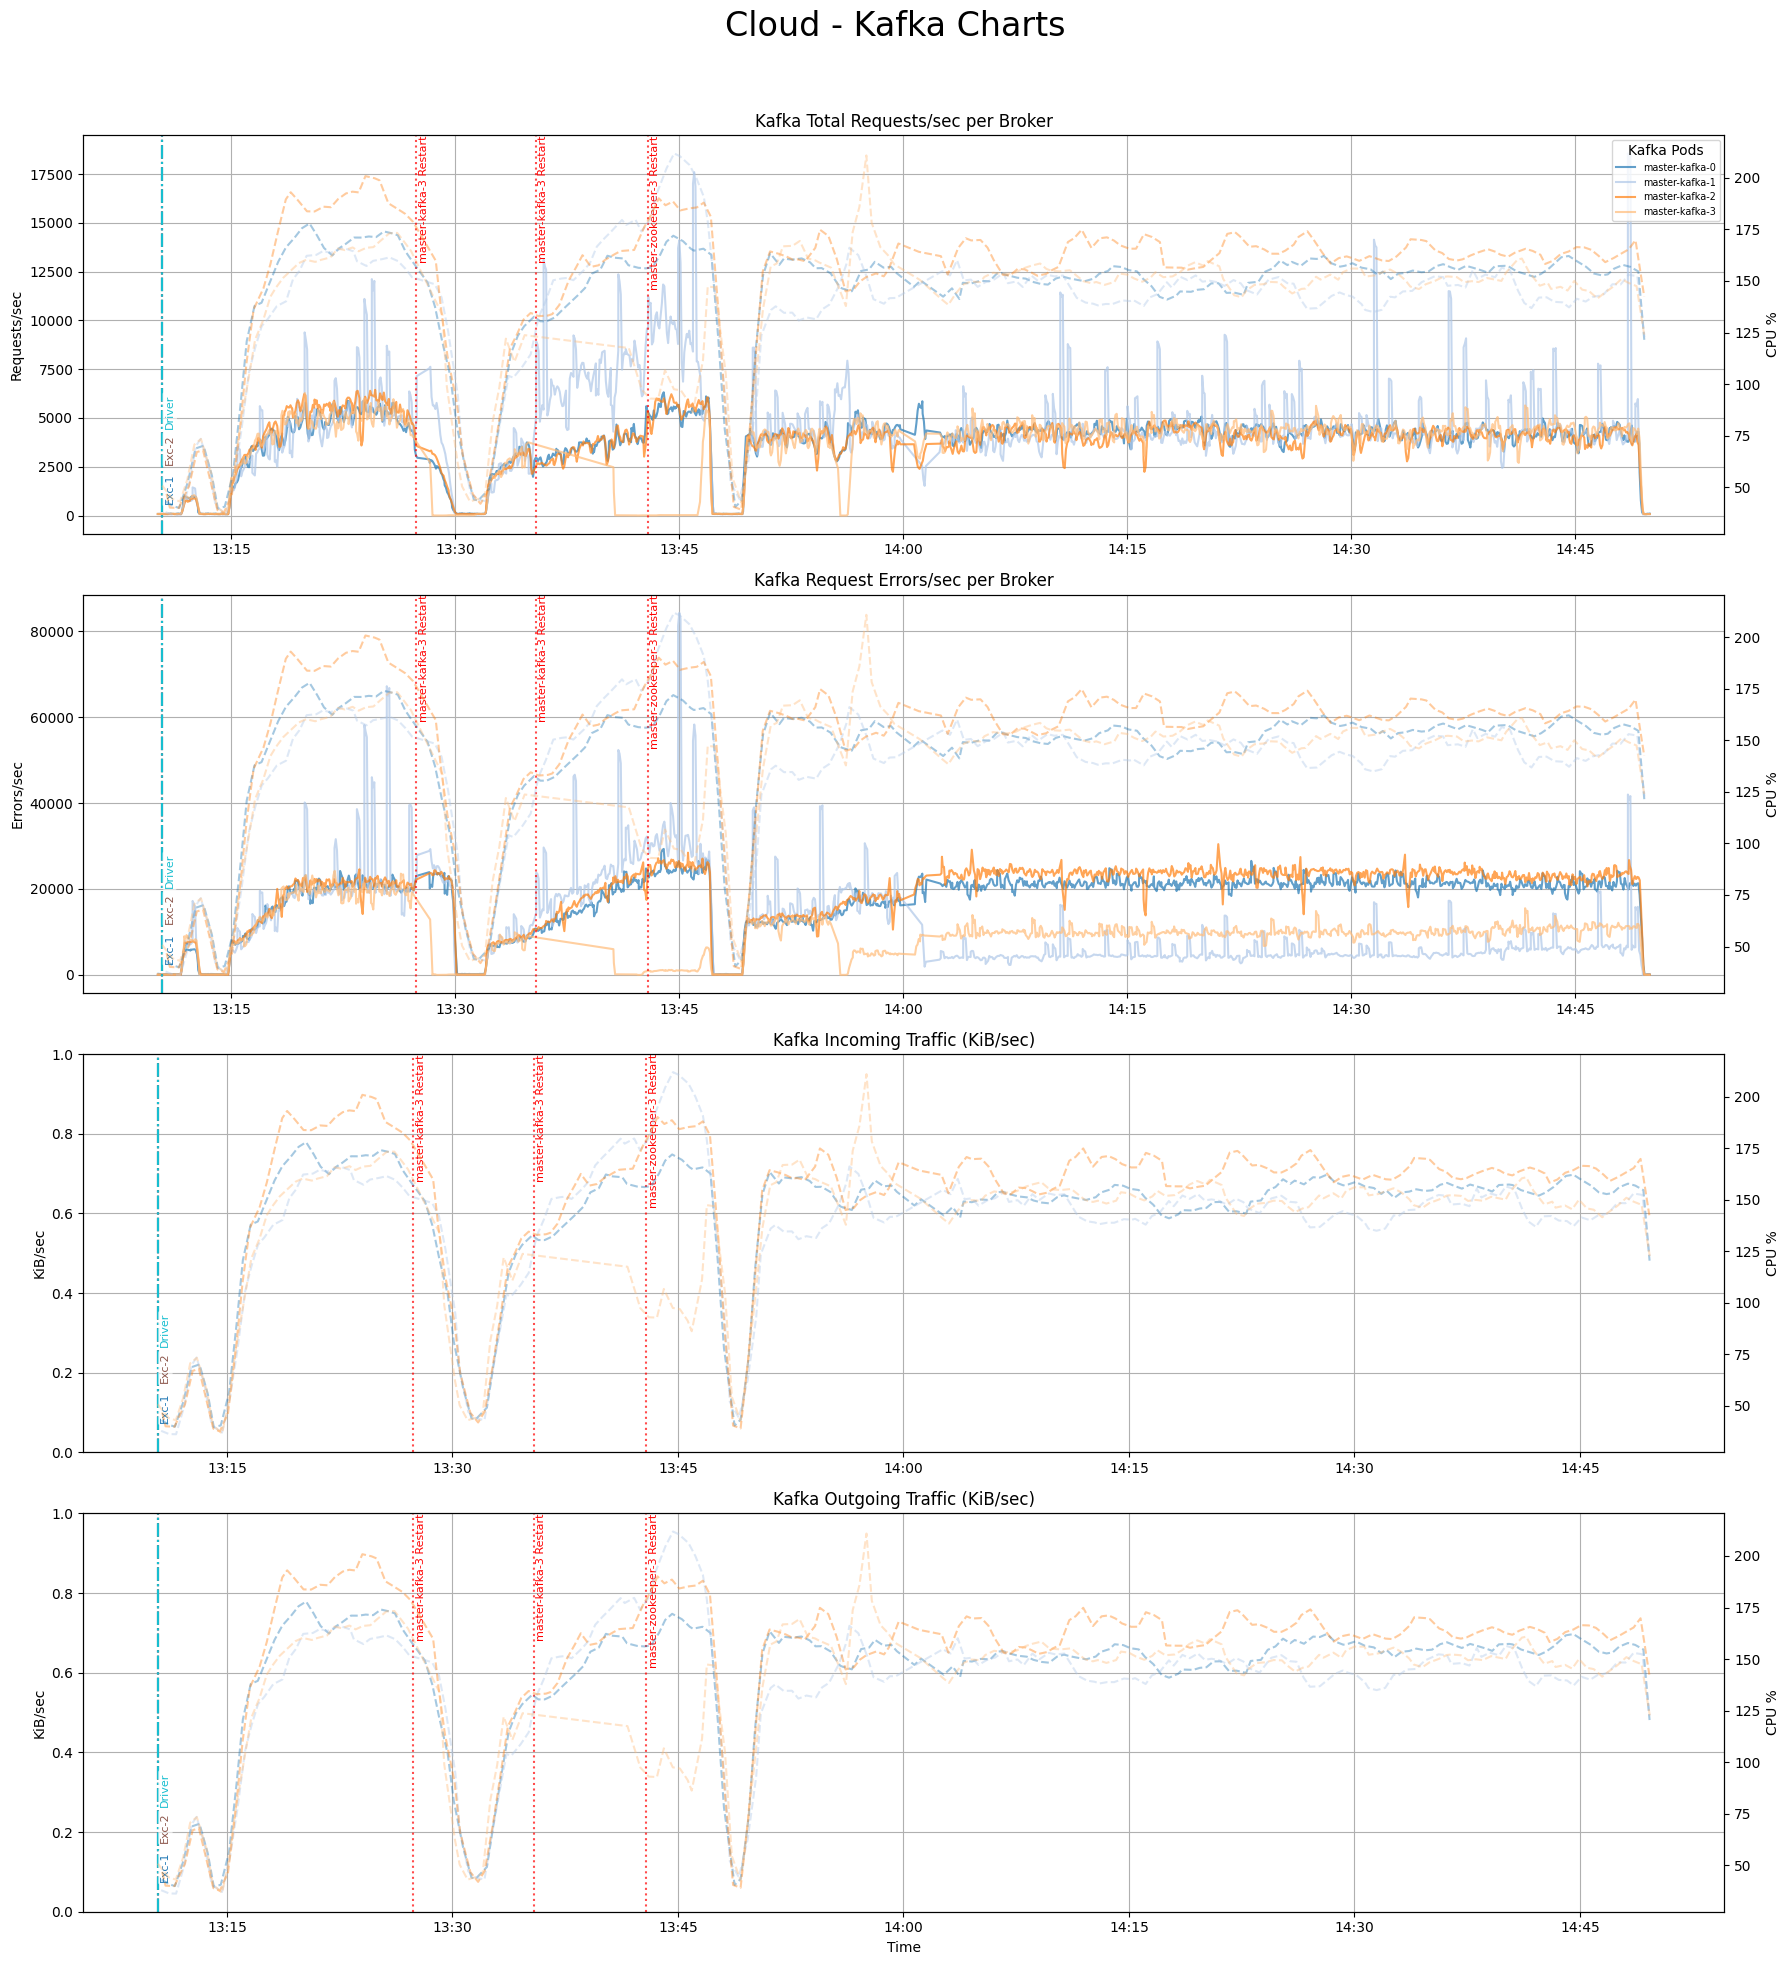

In [36]:
kafka_charts(kafka_bytes_in, kafka_bytes_out, kafka_requests, kafka_requests_errors, kafka_messages_in, df_container_cpu_usage_seconds_total, df_kube_pod_status_phase, title="Cloud - Kafka Charts")